In [1]:
suppressMessages(library(tidyr))
suppressMessages(library(dplyr))
suppressMessages(library(pheatmap))
suppressMessages(library(ggplot2))
suppressMessages(library(patchwork))
suppressMessages(library(ggtree))
suppressMessages(library(hash))
suppressMessages(library(RColorBrewer))
suppressMessages(library(reshape2))
suppressMessages(library(ggalluvial))
suppressMessages(library(grid))
suppressMessages(library(ggrepel))
suppressMessages(library(ggdark))
suppressMessages(library(tidyverse))
suppressMessages(library(ggrastr))
suppressMessages(library(ggpubr))
suppressMessages(library(readxl))
suppressMessages(library(ggsci))
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(circlize))
suppressMessages(library(aplot))
suppressMessages(library(Seurat))
suppressMessages(library(gridExtra))
suppressMessages(library(scales))
suppressMessages(library(colorspace))

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


# Function  

###  Figure A & G funtion 

In [2]:
GetGroupCenter <- function(df_umap, group){
  GroupCenter <- df_umap %>% group_by(eval(str2lang(group))) %>% summarise(UMAP_1 = median(UMAP_1),UMAP_2 = median(UMAP_2)) %>% as.data.frame()
  colnames(GroupCenter)[1] <- "GroupCenter"
  return(GroupCenter)
}

UmapPlot <- function(df, cluster, df_center, labelfontsize, axistitlefontsize, pointsize, pointalpha,
                    xmin,xmax,ymin,ymax,mycolor,axistitlefont,axislinesize,labelfont,
                    xaxislengthfold,yaxislengthfold){
  p <- ggplot() + 
    geom_point(df, mapping=aes(x = UMAP_1, y = UMAP_2, color = eval(str2lang(cluster))), size = pointsize, 
               alpha = pointalpha) +
    theme_void()+
    scale_x_continuous(limits = c(xmin-2, xmax))+
    scale_y_continuous(limits = c(ymin-2, ymax))+
    theme(axis.text = element_blank())+
    theme(axis.ticks = element_blank())+
    theme(panel.border = element_blank())+
    theme(axis.title = element_blank())+
    scale_color_manual(values=mycolor)+
    geom_segment(aes(x=xmin, y=ymin, xend=xmin+abs(xmin)*xaxislengthfold, yend=ymin), 
                 arrow = arrow(length=unit(0.2, "cm")), color="black", linewidth=axislinesize)+
    geom_segment(aes(x=xmin, y=ymin, xend=xmin, yend=ymin+abs(ymin)*yaxislengthfold), 
                 arrow = arrow(length=unit(0.2, "cm")), color="black", linewidth=axislinesize)+
    annotate("text", x = xmin + 1.5, y = ymin - 1, label = "UMAP_1",
             color="black",size = axistitlefontsize, fontface="bold", family = axistitlefont) +
    annotate("text", x = xmin - 1, y = ymin + 1.5, label = "UMAP_2",
             color="black",size = axistitlefontsize, fontface="bold" ,angle=90, family = axistitlefont) +
    geom_text(data = df_center[which(df_center$GroupCenter %in% unique(df[,cluster])),], mapping=aes(x = UMAP_1, y = UMAP_2, label=GroupCenter), 
              fontface="bold",color = "black",size = labelfontsize, family = labelfont)+
    theme(legend.position = "none")
  return(p)
}
RunUmapPlot <- function(obj,FilterCluster = NULL,umapCluster,ClusterColour = NULL,
                       specificgroup = NULL,umapGroup = NULL,
                       pointsize = 0.1,pointalpha = 0.5,
                       labelfontsize = 5,axistitlefontsize = 5,
                       axistitlefont = "sans",axislinesize = 1,
                       labelfont = "sans",plot_width = 10,plot_height = 8,
                        xaxislengthfold = 1,yaxislengthfold= 1,cellcycle_annotation = NULL,
                        saveannotation = TRUE,Legend = TRUE,legendnumsize = 3,
                       legendnumfont = "sans",legendlabelfontsize = 5,
                        legendlabelfont = "sans",legendwidth = 6,
                        legendheight = 5,file_name){
    df_umap_ct = obj@reductions$umap@cell.embeddings %>%
      as.data.frame() %>% 
      cbind(Cluster = obj@meta.data$clusters) %>%
      cbind(Group = obj@meta.data$mice) 
    if (is.null(obj@meta.data$tissue2)){
      df_umap_ct$Tissue <- obj@meta.data$tissue
    }else{
      df_umap_ct$Tissue <- obj@meta.data$tissue2
    }
    if (!is.null(obj@meta.data$platform)){
      df_umap_ct$Platform <- obj@meta.data$platform
      df_umap_ct$Platform <- as.factor(df_umap_ct$Platform)
    }

    df_umap_ct$Cluster <- as.factor(df_umap_ct$Cluster)
    df_umap_ct$Cluster <- factor(df_umap_ct$Cluster, levels=sort(as.numeric(levels(df_umap_ct$Cluster))))
    df_umap_ct$Group <- as.factor(df_umap_ct$Group)
    df_umap_ct$Tissue <- as.factor(df_umap_ct$Tissue)

    if (!is.null(FilterCluster)){
      if (filtercluster_var == umapCluster){
        df_umap_ct <- df_umap_ct[which(!df_umap_ct[,umapCluster] %in% FilterCluster),]
      }else{
        df_umap_ct <- df_umap_ct[which(!df_umap_ct[,filtercluster_var] %in% FilterCluster),]
      }
    }

    xmin <- min(df_umap_ct$UMAP_1)-2
    xmax <- max(df_umap_ct$UMAP_1)+2
    ymin <- min(df_umap_ct$UMAP_2)-2
    ymax <- max(df_umap_ct$UMAP_2)+2
    
    # lwm 
    # print(head(df_umap_ct))

    ct_center <- GetGroupCenter(df_umap_ct, umapCluster)
    

    nCluster = length(unique(df_umap_ct[,umapCluster]))

    if (is.null(ClusterColour)){
      mycolor = colorRampPalette(brewer.pal(9, "Set1"))(nCluster)
      names(mycolor) <- levels(df_umap_ct[,umapCluster])[sort(unique(df_umap_ct[,umapCluster]))]
    }else{
      if (is.null(names(ClusterColour))){
        mycolor <- ClusterColour
        names(mycolor) <- levels(df_umap_ct[,umapCluster])[sort(unique(df_umap_ct[,umapCluster]))]
      }else{
        mycolor <- ClusterColour
      }
    }

  
    if (is.null(specificgroup)){
      if (is.null(umapGroup)){
        umap_overall <- UmapPlot(df_umap_ct, umapCluster, ct_center, labelfontsize, axistitlefontsize,
                                 pointsize, pointalpha,xmin,xmax,ymin,ymax,mycolor,axistitlefont,axislinesize,
                                 labelfont,xaxislengthfold,yaxislengthfold)
        ggsave(paste0(file_name,"_umap_overall_",umapCluster,".pdf"),umap_overall,device='pdf',width = plot_width, 
               height = plot_height)
      }
    }

    if (is.null(cellcycle_annotation)){
      ct_anno <- unique(data.frame(Cluster=obj@meta.data$cluster, ClusterName=obj@meta.data$celltypes))
      ct_anno$Cluster <- factor(ct_anno$Cluster, levels=sort(as.numeric(levels(ct_anno$Cluster))))
      cellcycle_annotation <- ct_anno[order(ct_anno$Cluster, decreasing = F),]
      if (!is.null(FilterCluster)){
        cellcycle_annotation <- cellcycle_annotation[which(!cellcycle_annotation$Cluster %in% FilterCluster),]
      }
  if (saveannotation){
    write.table(cellcycle_annotation, paste0(file_name,"_cellcycle_annotation.txt"), 
                                             sep = "\t", quote = F, row.names = F)
  }
    }else{
      cellcycle_annotation <- read.table(cellcycle_annotation, sep="\t", header = T)
      cellcycle_annotation$Cluster <- as.factor(cellcycle_annotation$Cluster)
      cellcycle_annotation$Cluster <- factor(cellcycle_annotation$Cluster, levels=sort(as.numeric(levels(cellcycle_annotation$Cluster))))
      cellcycle_annotation <- cellcycle_annotation[order(cellcycle_annotation$Cluster),]
    }

    if (Legend){
      if (!is.null(FilterCluster)){
        cellcycle_annotation <- cellcycle_annotation[which(!cellcycle_annotation$Cluster %in% FilterCluster),]
      }
  
      xend <- ceiling(nCluster/15)
      xeach <- ceiling(nCluster/xend)
      xlist <- sort(rep(c(1:xend), each=xeach, length.out = nCluster))
      df_xlist <- table(xlist) %>% as.data.frame()
      ylist <- rep(c(max(df_xlist$Freq):1),nrow(df_xlist), length.out=nCluster)
  
      df_legend <- cellcycle_annotation
      df_legend$x <- xlist
      df_legend$y <- ylist
  
      p_lgd <- ggplot(df_legend, aes(x=x, y=y))+
        geom_point(alpha=1, size=6,aes(colour=as.factor(Cluster)))+
        labs(x='',y='',title="")+
        geom_text(aes(x=x, y=y,label=Cluster), fontface="bold",color = "black",size = legendnumsize,
                  family = legendnumfont)+
        geom_text(aes(x=x+xend*0.03, y=y,label=ClusterName), fontface="bold",color = "black",
                  size = legendlabelfontsize, family = legendlabelfont, hjust = 0)+
        theme_void()+
        scale_x_continuous(limits = c(1, xend+1))+
        theme(axis.text = element_blank())+
        theme(axis.ticks = element_blank())+
        theme(panel.border = element_blank())+
        theme(axis.title = element_blank())+
        scale_color_manual(values=mycolor)+
        theme(legend.position = "none")
      ggsave(paste0(file_name,"_umap_legend.pdf"),p_lgd,device='pdf',width = legendwidth, height = legendheight) 
    }
    plst <- list(p = umap_overall,lgd = p_lgd)
    return(plst)
}

### Figure B & H function 

In [3]:
CellCyclePlot <- function(df, groupname,labelfontsize,labelfont,plottitlefontsize,
                          plottitlefont,mycolor2,file_name){
  df$Overall <- apply(df,1,sum)
  
  SumAll <- sum(df$Overall)
  df$gap <- SumAll*0.01
  df$Overall <- NULL
  df <- rownames_to_column(df, var = "Cluster")

  df_long <- reshape2::melt(df, id.var="Cluster", variable.name="CellCycle", value.name = "Value")
  
  df_long$Cluster <- as.factor(df_long$Cluster)
  df_long$Cluster <- factor(df_long$Cluster, levels=sort(as.numeric(levels(df_long$Cluster))))
  df_long$CellCycle <- factor(df_long$CellCycle, levels=c("G1","G2M","S","gap"))
  
  df_long <- df_long[order(df_long[,"Cluster"],df_long[,"CellCycle"]),]
  
  df_long$fraction = df_long$Value / SumAll
  df_long$ymax = cumsum(df_long$fraction)
  df_long$ymin = c(0, head(df_long$ymax, n = -1))
  
  write.csv(df_long, paste0(file_name,"_df_long_",groupname,".csv"),row.names = F) # ok # 
  
  df_long_center <- df_long[which(df_long$CellCycle!="gap"),c("Cluster","ymax","ymin")]
  df_center <- reshape2::melt(df_long_center, id.var="Cluster")
  df_center_y <- df_center %>% group_by(Cluster) %>% dplyr::summarise(ymin=min(value),
                                                                      ymax=max(value)) %>% as.data.frame()
  df_center_y$ymean <- (df_center_y$ymax + df_center_y$ymin)/2
    
  p <- ggplot() +
    geom_rect(data = df_long[which(df_long$CellCycle!="gap"),], aes(fill = Cluster, ymax = ymax, ymin = ymin, xmax = 7, xmin = 3),show.legend = F) +
    geom_rect(data = df_long[which(df_long$CellCycle=="gap"),], aes( ymax = ymax, ymin = ymin, xmax = 7, xmin = 3),fill = "black",show.legend = F) +
    geom_rect(data = df_long, aes(fill = CellCycle, ymax = ymax, ymin = ymin, xmax = 8, xmin = 7.1),show.legend = F) +
    geom_text(data = df_center_y, aes(x=rep(9,nrow(df_center_y)),y=ymean,label=Cluster), fontface="bold",
              color = "black",size = labelfontsize, family = labelfont)+
    annotate("text", x = 0.1, y = median(df_long$ymax), label = groupname,
             color="black",size = plottitlefontsize, family = plottitlefont, fontface="bold", angle=0)+
    scale_fill_manual(values=mycolor2)+
    coord_polar(theta = "y") +
    xlim(c(0, 10)) +
    # theme_light() +
    theme_bw()+
    labs(x="",y="")+
    theme(panel.grid=element_blank()) + 
    theme(axis.text=element_blank()) + 
    theme(axis.ticks=element_blank()) + 
    theme(panel.border=element_blank()) 
  return(p)
}

df_rename <- function(df, annote_ct){
  df_merged <- merge(df, annote_ct, by.x="row.names", by.y="ClusterName")
  rownames(df_merged) <- df_merged$Cluster
  df_merged <- df_merged[order(df_merged$Cluster),]
  df_merged$Cluster <- NULL
  df_merged$Row.names <- NULL
  return(df_merged)
}
 
df_annot <- function(df){
  df_a_s <- NULL
  df <- rownames_to_column(df, var = "ClusterName")
    
  df$Cluster  <- seq(0,length(df$ClusterName) - 1,1)# lwm  number of Cluster ! 
    
  ct_annotation <- df[,c("Cluster","ClusterName")]
  df_selected <- df %>% select(-c("ClusterName")) %>% column_to_rownames("Cluster")
  df_a_s[[1]] <- ct_annotation
  df_a_s[[2]] <- df_selected
  return(df_a_s)
}
RunCellCyclePlot <- function(data,file_name,FilterCluster= NULL,cellcycle_annotation=NULL,
                            ClusterColour = NULL,CellCycleColour = NULL,
                            labelfontsize = 5,labelfont = "sans",plottitlefontsize = 5,
                         plottitlefont = "sans",plot_width =10,plot_height = 8,
                            Legend = TRUE,legendnumsize = 3,
                       legendnumfont = "sans",legendlabelfontsize = 5,
                        legendlabelfont = "sans",legendwidth = 6,
                        legendheight = 5){
    
    GF_Phase <- data %>% filter(mice == "GF")
    GF_Phase <- as.data.frame.array(table(GF_Phase$clusters,GF_Phase$Phase))
    
    SPF_Phase <- data %>% filter(mice == "SPF")
    SPF_Phase <- as.data.frame.array(table(SPF_Phase$clusters,SPF_Phase$Phase))

    if (!is.null(FilterCluster)){
      GF_Phase <- GF_Phase[which(!GF_Phase$clusters %in% FilterCluster),] # filter cluster !! lwm 
      SPF_Phase <- SPF_Phase[which(!SPF_Phase$clusters %in% FilterCluster),]
    }

    if (!is.null(cellcycle_annotation)){
      cellcycle_annotation <- read.table(cellcycle_annotation, sep="\t", header = T)
      GF_Phase <- df_rename(GF_Phase, cellcycle_annotation)
      SPF_Phase <- df_rename(SPF_Phase, cellcycle_annotation)
    }else{
      GF_annot_res <- df_annot(GF_Phase)
      GF_Phase <- GF_annot_res[[2]]
      SPF_annot_res <- df_annot(SPF_Phase)
      SPF_Phase <- SPF_annot_res[[2]]
      cellcycle_annotation <- SPF_annot_res[[1]]
    }

    nCluster = nrow(GF_Phase)

    if (is.null(ClusterColour)){
      mycolor = colorRampPalette(brewer.pal(9, "Set1"))(nCluster)
      names(mycolor) <- rownames(GF_Phase)
    }else{
      if (is.null(names(ClusterColour))){
        mycolor <- ClusterColour
        names(mycolor) <- rownames(GF_Phase)
      }else{
        mycolor <- ClusterColour
      }
    }

    if (is.null(CellCycleColour)){
      CellCycleColour <- c("#0073C2FF", "#EFC000FF", "#CD534CFF")
    }
    mycolor2 <- c(mycolor, "G1"=CellCycleColour[1], "G2M"=CellCycleColour[2], "S"=CellCycleColour[3],"gap"="black")
    ccp_gf <- CellCyclePlot(GF_Phase,groupname= "GF",labelfontsize,labelfont,plottitlefontsize,plottitlefont,
                           mycolor2,file_name)
    ccp_spf <- CellCyclePlot(SPF_Phase,groupname="SPF",labelfontsize,labelfont,plottitlefontsize,plottitlefont,
                             mycolor2,file_name)
    ccp_group <- ggarrange(ccp_gf, ccp_spf, ncol = 2, nrow = 1) 
    
    ggsave(paste0(file_name,"_CellCyclePlot_group.pdf"),ccp_group,device='pdf',
                  width = plot_width, height = plot_height)

    if (Legend){
      if (!is.null(FilterCluster)){
        cellcycle_annotation <- cellcycle_annotation[which(!cellcycle_annotation$Cluster %in% FilterCluster),]
      }
  
      xend <- ceiling(nCluster/15)
      xeach <- ceiling(nCluster/xend)
      xlist <- sort(rep(c(1:xend), each=xeach, length.out = nCluster))
      df_xlist <- table(xlist) %>% as.data.frame()
      ylist <- rep(c(max(df_xlist$Freq):1),nrow(df_xlist), length.out=nCluster)
  
      df_legend <- cellcycle_annotation
      df_legend$x <- xlist
      df_legend$y <- ylist
  
      df_legend2 <- data.frame(Cluster=c("G1","G2M","S"))
      df_legend2$Cluster <- as.factor(df_legend2$Cluster)
      df_legend2$y <- c(rep(0,3))
      df_legend2$x <- c(seq(1,3))
  
      p_lgd2 <- ggplot(df_legend2, aes(x=x, y=y))+
        geom_rect(data = df_legend2, aes(fill = as.factor(Cluster), ymax = y+0.02, ymin = y-0.02, xmax = x+0.05, xmin = x-0.05),show.legend = F)+
        labs(x='',y='',title="")+
        geom_text(aes(x=x+0.1, y=y,label=Cluster), fontface="bold",color = "black",size = legendlabelfontsize, family = legendlabelfont, hjust = 0)+
        geom_text(aes(x=1, y=0.1, label="Cell Cycle"), fontface="bold",color = "black",size = 6, family = legendlabelfont, hjust = 0)+
        # theme_map()+
        theme_void()+
        scale_x_continuous(limits = c(-0.5, 4))+
        scale_y_continuous(limits = c(-0.5, 0.5))+
        theme(axis.text = element_blank())+
        theme(axis.ticks = element_blank())+
        theme(panel.border = element_blank())+
        theme(axis.title = element_blank())+
        scale_fill_manual(values=CellCycleColour)+
        theme(legend.position = "none")
      ggsave(paste0(file_name,"_CellCyclePlot_legend2.pdf"),p_lgd2,device='pdf',
             width = legendwidth, height = legendheight)
    }
    plst <- list(ccp = ccp_group,lgd = p_lgd2)
    return(plst)
}

### Figure C & I function 

In [4]:
dotplot_custom <- function(df_nums,rowlist,collist,col_names){
    df_nums$celltypes <- rownames(df_nums)
    range01 <- function(x){(x - min(x)) / (max(x) - min(x))}
    df_prop <-  df_nums %>% select(-c("celltypes"))
    df_prop <- apply(df_prop, 2, function(x){x/sum(x)*100})
    rewrite0_row <- which(apply(df_prop,1,min)!=0)
    df_prop <- as.data.frame(t(apply(df_prop, 1, range01)))
    minpseudo <- min(df_prop[df_prop!=0])/2
    for (i in rewrite0_row){
      df_prop[i,which(df_prop[i,]==0)] <- minpseudo
    }
    df_prop$celltypes <- df_nums$celltypes
    
    df_prop_long <- reshape2::melt(df_prop, id.var='celltypes', variable.name='Organs', value.name = "Propstat")
    df_nums_long <- reshape2::melt(df_nums, id.var='celltypes', variable.name='Organs', value.name = "Numstat")

    df_long <- dplyr::left_join(df_prop_long,df_nums_long,by=c("celltypes","Organs"))
    df_long$celltypes <- as.factor(df_long$celltypes)
    df_long$Organs <- as.factor(df_long$Organs)
    df_long$Numstat[df_long$Numstat==0] <- NA 
    df_long$Propstat[df_long$Propstat==0] <- NA

    df_newname <- data.frame(celltypes=rowlist, newname= rowlist)

    df_long_newname <- merge(df_long,df_newname,by="celltypes",all.x = T)

    df_long <- df_long_newname[,c(5,2,3,4)]
    colnames(df_long)[1] <- "celltypes"
    
    #print(head(df_long)) 
    print(unique(df_long$celltypes)) 
    df_long$celltypes <- factor(df_long$celltypes, levels = rev(df_newname$newname))
    df_long$Organs <- factor(df_long$Organs, levels = c(collist))
    df_long$Numstat <- cut(df_long$Numstat, breaks = c(-Inf, 100, 250, 500, 750, 1000, 5000, Inf), 
                           labels = c("1-100", "101-250", "251-500", "501-750", "750-1000", "1000-5000", ">5000"), right=FALSE)

    p <- ggplot(df_long,aes(x=Organs,y=celltypes))+
              geom_point(aes(size=Propstat, color=Numstat))+
              theme_bw()+
                guides(shape = guide_legend(override.aes = list(size=20)))+
          theme(axis.text.x = element_text(size = 15, face="bold", vjust = 0.5, hjust = 0.5, angle = 0),
                axis.text.y = element_text(size = 15, face="bold"))+
          theme(legend.title = element_text(size = 15, face="bold"),
                legend.text = element_text(size = 13)) +
          scale_color_manual(values = col_names[3:10]) +  labs(x=NULL,y=NULL)  + coord_flip() 
    return(p)
}
# use cluster # 
GetMergeTable <- function(object,var){
    print(object)
    whole <- as.data.frame.array(table(object@meta.data$clusters,object@meta.data$mice))
    #print(whole)
    Idents(object) <- var
    for( i in unique(object@meta.data[,var])){
        print(i)
        subObj <- subset(object, idents = i)
        tissue_table <- as.data.frame.array(table(subObj@meta.data$clusters,subObj@meta.data$mice))
        tissue_prefix <- rep(i,2)
        table_newnames <- paste(colnames(tissue_table),tissue_prefix,sep = "_")
        colnames(tissue_table) <- table_newnames
        whole <- cbind(whole,tissue_table)
    }
    return(whole)
} 

### Figure D & L  function 

In [5]:
DEGBarplot <- function(dat,sample,idx = c("GF","SPF")){  # count # 
  print(idx)
  sample_names <- c(paste0(idx[1]," up-regulated"), paste0(idx[2]," up-regulated"))
  dat <- dat %>%
    dplyr::mutate(group_type = factor(ifelse(group == 1, sample_names[1], sample_names[2]), levels = sample_names)) %>%
    dplyr::mutate(Gene_Number = pvalue * group) %>% dplyr::arrange(pvalue) # add up arrange pvalue
  # 6print(head(dat,20))
  dat <- dat %>% dplyr::group_by(group) %>% dplyr::do(head(., n = 10)) %>% as.data.frame()
  dat$log10Pvalue <- -(log10(dat$pvalue))
  th <- theme(plot.title = element_text(size = 25,vjust = 0.5,hjust = 0.05),
              axis.text.y= element_blank(),
              axis.ticks.y= element_blank(),
              axis.title.x = element_text(size = 30),
              axis.line.x = element_line(size = 1),
              axis.ticks.x = element_line(size = 1),
              axis.text.x = element_text(size = 20),
              panel.background = element_rect(fill = 'white'),
              panel.border = element_rect(color = 'white', fill = NA),
              panel.grid.major.y = element_blank(),
              panel.grid.minor.y = element_blank(),
              panel.grid.major.x = element_line(colour = "grey80", linetype = "dashed"),
              panel.grid.minor.x = element_blank(),
              legend.text=element_text(size=15),
              legend.title= element_text(size=20), 
              plot.margin = unit(c(0.5,1,0.5,0.5),"cm"),
              legend.direction = "horizontal") # colorbar horizontal # 
  get_wraper <- function(width) {
    function(x) {
      lapply(strwrap(x, width = width, simplify = FALSE), paste, collapse="\n")
    }
  }
  plst <- list()
  colorbar <- data.frame(low = c("#FADDC3","#ADCCF6"),high = c("#983b3a","#537497"))
  for(i in 1:length(idx)){
    pfx <- idx[i]
    print(pfx)
    pdata <- dat %>% filter(mice == pfx) # condition # 
    plst[[pfx]] <- ggplot(pdata, aes(x = reorder(Description, Count,decreasing = T), y = Count)) +  
      geom_bar(aes(fill = log10Pvalue), stat = "identity") + th + 
      labs(x = '', y = '', fill = sample_names[i],title = pfx) + 
      scale_fill_gradient(low = colorbar$low[i] , high = colorbar$high[i]) +  
      coord_flip()  + scale_y_continuous(labels = function(x)sprintf("%.1f",x)) + 
      geom_text(aes(y = ifelse(Gene_Number > 0,0,0), 
                    label= as.vector(Description),
                    hjust = 0),color = "black",
                   size = 5,vjust = 0.5)
  }
  #
  plst[[1]] <- plst[[1]] +  guides(fill=guide_colorbar(title = paste("-log10Pvalue","\n\n",sample_names[1],
                                                                    sep = ""),
                                                      title.position = "top",
                                                      ))
  plst[[2]] <- plst[[2]] + labs(y='Count') + guides(fill=guide_colorbar(title.position = "top"))
   p <- plst[[1]] / plot_spacer() / plst[[2]] / plot_layout(guides = 'collect',# axes ="collect_x",
                                                            heights = c(4,-1.05,4))  & 
     #theme(legend.position = 'left') &
    plot_annotation(
      title = sample,
      theme = theme(plot.title = element_text(size = 30,vjust = 0.5,hjust = 0.5)))
  
  return(p)
}

# Figure 3A 

In [86]:
mye <- readRDS("immune_myeloid_final_annotation.rds") 

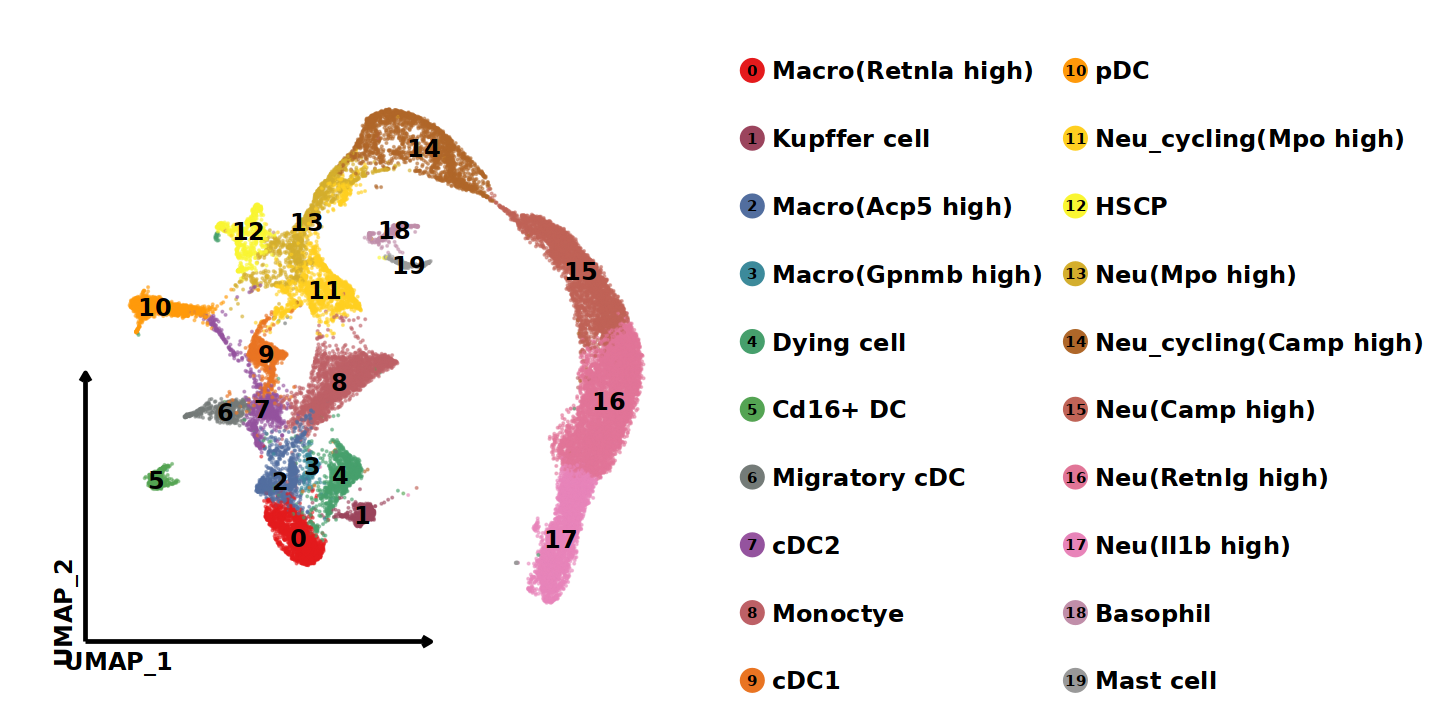

In [94]:
p <- RunUmapPlot(mye,umapCluster = "Cluster",file_name = "Figure_3A_myeloid")
options(repr.plot.width =12,repr.plot.height= 6)
p[["p"]] + p[["lgd"]] 

# Figure 3B 

In [161]:
mye_df <- mye@meta.data %>% select(mice,Phase,clusters)
write.table(mye_df,file = "Figure_3B_myeloid.xls",sep = "\t",quote = F)
p <- RunCellCyclePlot(data = mye_df,file_name = "Figure_3B_myeloid")

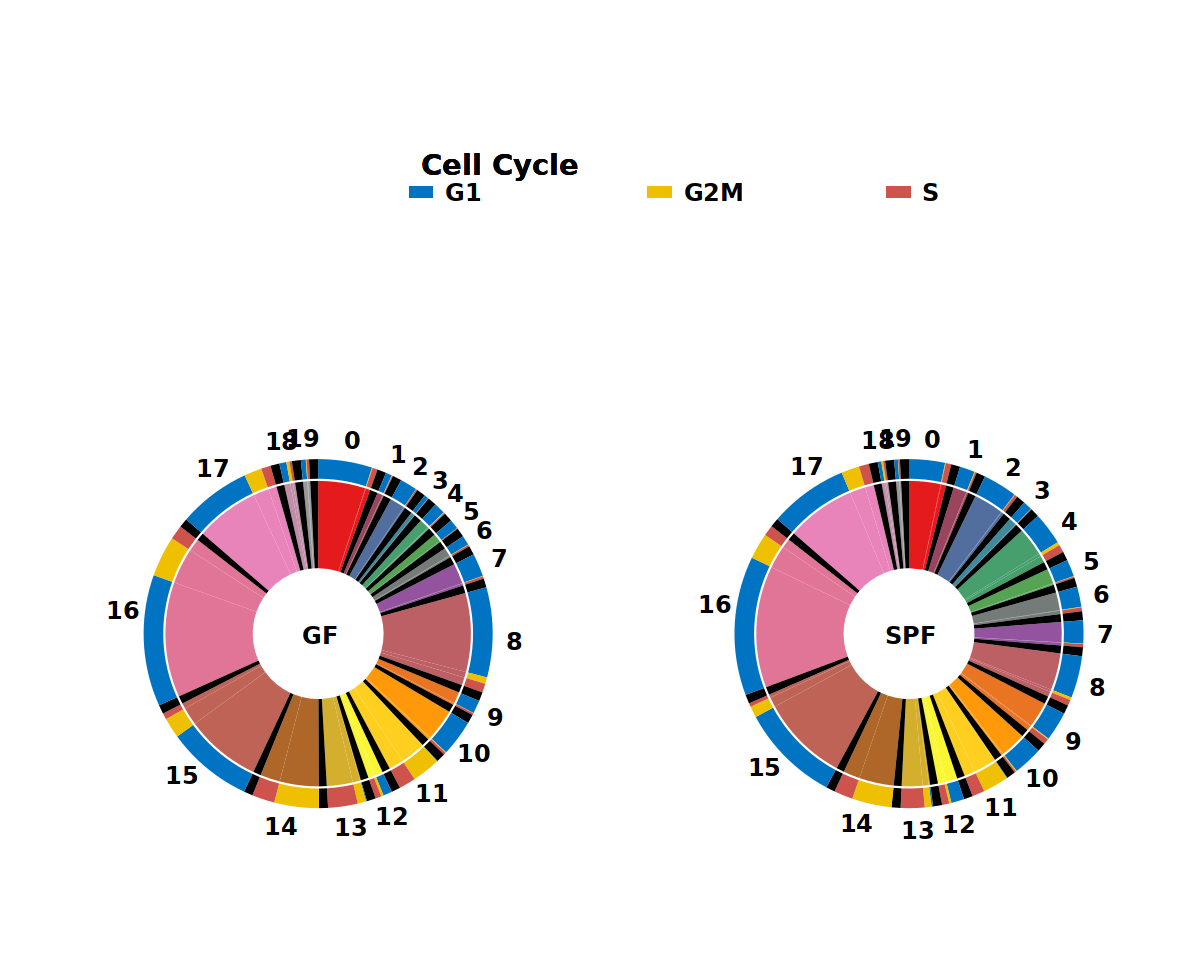

In [162]:
options(repr.plot.width =10,repr.plot.height= 8)
p[["lgd"]] / p[["ccp"]] + plot_layout(heights = c(1,2))

# Figure 3C

In [40]:
mye_dat <- GetMergeTable(object = mye, var = "tissue")
rowlist = c(12,14,13,15,16,11,17,8,3,7,1,10,2,0,4,9,6,19,18,5)
write.table(mye_dat,file = "Figure_3C_myeliod.xls",sep = '\t',quote = F)

An object of class Seurat 
32864 features across 31998 samples within 2 assays 
Active assay: RNA (30870 features, 0 variable features)
 1 other assay present: integrated
 3 dimensional reductions calculated: pca, umap, tsne
[1] "blood"
[1] "bm"
[1] "liver"
[1] "spleen"
[1] "thymus"
[1] "cecum"
[1] "colon"
[1] "ileum"


 [1]  0  1 10 11 12 13 14 15 16 17 18 19  2  3  4  5  6  7  8  9


Warning message:
“Removed 83 rows containing missing values (`geom_point()`).”


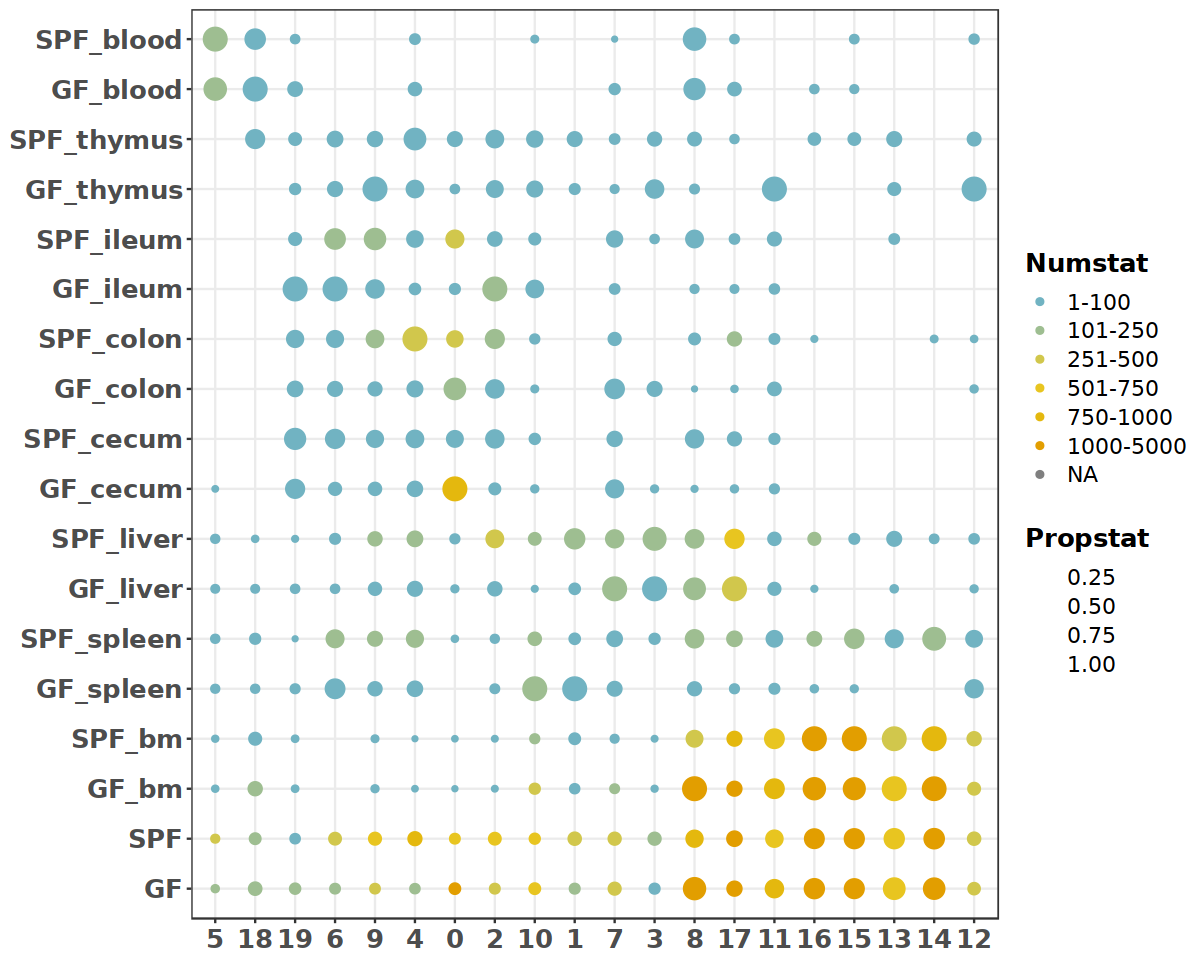

In [41]:
# parameter # 
collist <- c("GF","SPF",
             "GF_bm","SPF_bm",
             "GF_spleen","SPF_spleen",
             "GF_liver","SPF_liver",
             "GF_cecum","SPF_cecum",
             "GF_colon","SPF_colon",
             "GF_ileum","SPF_ileum",
             "GF_thymus","SPF_thymus",
             "GF_blood","SPF_blood")
col_names <- c("#3B9AB2","#56A6BA","#71B3C2","#9EBE91","#D1C74C",
               "#E8C520","#E4B80E","#E29E00","#EA5C00","#F21A00")
options(repr.plot.width = 10,repr.plot.height= 8)
p <- dotplot_custom(df_num = mye_dat, rowlist = rowlist,collist =  collist,col_names = col_names)  
p

In [42]:
pdf(file = 'Figure_3C_myeliod_dotplot.pdf',w = 10, h = 8)
print(p)
dev.off()

Warning message:
“Removed 83 rows containing missing values (`geom_point()`).”


png 
  2

# Figure 3D

In [43]:
mye_go <- read.csv("Myeloid_ALL_GO.xls",sep = "\t")
mye_neu <- mye_go %>% filter(celltypes == ' Neu(Il1b high)')

[1] "GF"  "SPF"


Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


[1] "GF"
[1] "SPF"


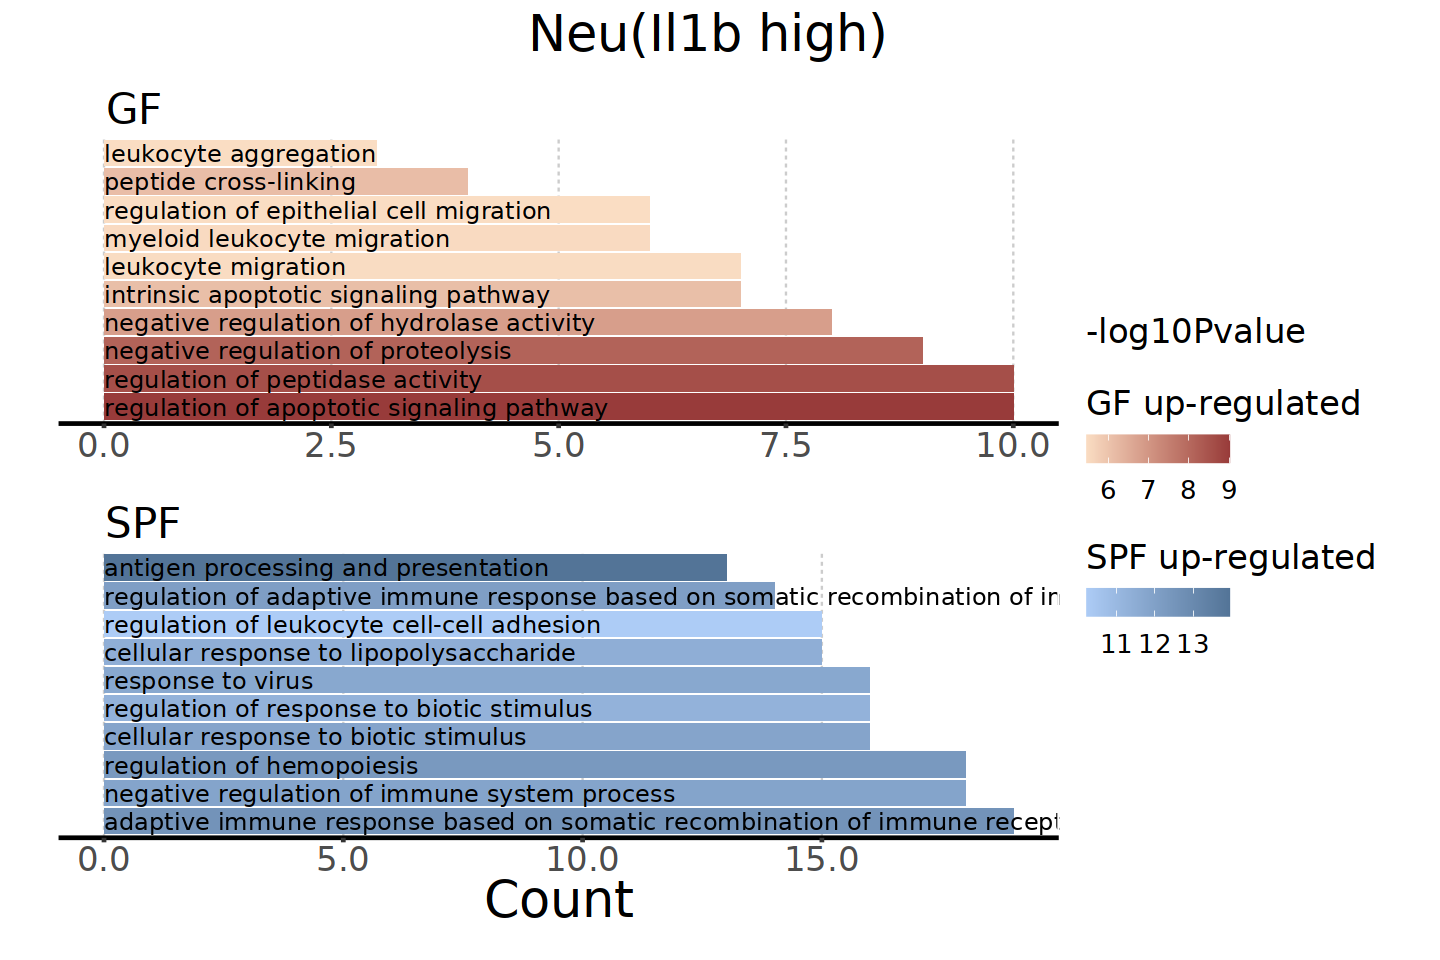

In [46]:
options(repr.plot.width =12,repr.plot.height= 8)
p <- DEGBarplot(dat = mye_neu,sample = "Neu(Il1b high)")
p

In [47]:
pdf(file = 'Figure_3D_myeliod_deg_barplot.pdf',w = 12, h = 8)
print(p)
dev.off()

png 
  2

# Figure 3E

In [48]:
CellMiceRadioBarplot <- function(data,x,y,fill,mycolor,title = NULL,
                                 legend = "vertical",nrow = 2,y_label = "Percentage (%)"){ 
  theme_self <- theme(
    axis.text.y = element_text(size = 20,face = "bold",margin  = margin(0,5,0,0)),
    axis.text.x = element_text(size = 20,face = "bold",margin  = margin(5,0,0,0),angle = 0,hjust = 0.5,vjust =0.5),
    axis.title.x= element_text(size = 25,face = "bold",margin  = margin(0,0,0,0)),
    axis.title.y= element_text(size = 25,face = "bold",margin  = margin(0,0,0,0)),
    axis.line = element_line(linetype = 1,color= "black",size = 1),
    legend.text = element_text(size = 18,face = "bold"),
    legend.title = element_text(size = 25,face = "bold"),
    panel.grid = element_blank(),
    plot.margin =  unit(c(1,1,1,1),"cm"), 
    axis.ticks  = element_line(color = "black",size = 1,lineend = 2),
    plot.title = element_text(hjust = 0.5,size = 30,face = "bold"))
  p <- ggplot(data,aes_string(x = x,y = y,fill = fill)) + 
    geom_bar(stat="identity",width = 0.5,colour = 'black') + theme_classic() + 
    labs(x = " " , y = y_label) +  #0.25 
    scale_fill_manual(values=mycolor) + theme_self  
  if(legend == "vertical"){  
      p <- p +  theme(legend.position  = "top") +
                 guides(fill=guide_legend(title = title,title.position = "top",nrow = nrow))  
              
  } else if (legend == "horizontal"){
      p <- p + theme(legend.position = "top",legend.title = element_blank()) + 
                  guides(fill=guide_legend(nrow =nrow)) 
  } else {
      stop("Please check your parameter of legend!")
  }
  return(p)
}
# cell radio 
GetCellRadio <- function(obj,index = c("Neutrophil(Il1b high)","Neutrophil(S100a8 high)"),
                         type = "Neutrophil"){
    data <- as.data.frame.array(table(spleen@meta.data$celltypes,spleen@meta.data$mice))
    data <- as.data.frame(proportions(as.matrix(data),margin = 2) * 100) 
    data <- data[rownames(data) %in% index,]
    data$celltypes <- type
    data <- data %>% group_by(celltypes) %>% summarise(GF = sum(GF),SPF = sum(SPF)) %>% as.data.frame()
    data <- melt(data,id.vars = "celltypes")
    colnames(data) <- c("celltypes","mice","percentage")
    return(data)
}
# gene experssion stat #  
GetFeatureRadio <- function(obj,feature,mice){
    exp <- FetchData(object = obj,vars = feature) 
    stat <- as.data.frame(Matrix::rowSums(x = exp > 0)) # Get experssion gene 
    colnames(stat) <- "ExpStat"
    exp_radio <- length(stat[stat[,'ExpStat'] != 0,])/length(stat$ExpStat) * 100
    cat(paste(mice," feature experssion : ",round(exp_radio,3),"%","\n",sep = ""))
    data <- data.frame(mice = mice,percentage = exp_radio)
    return(data)
}

In [57]:
level <- c("SPF","GF")
mycolor <- c("grey60","#ADCCF6")
names(mycolor) <- level

In [58]:
# scRNA-seq of spleen # 
spleen <- readRDS("spleen_final_annotation.rds")

In [59]:
data <- GetCellRadio(obj = spleen)
data$mice <- factor(data$mice,levels = level)
data

celltypes,mice,percentage
<chr>,<fct>,<dbl>
Neutrophil,GF,0.07907014
Neutrophil,SPF,3.95244386


In [60]:
sc <- CellMiceRadioBarplot(data = data,mycolor = mycolor,x = "mice",y = "percentage",fill = "mice",
                    title = "scRNA-seq of spleen",legend = "vertical",nrow =2,
                          y_label = "The proportion \n of Neutrophil(%)") + ylim(0,8)

In [61]:
# stereo-seq of spleen # 
gf_spleen <- readRDS("GF_spleen.bin50.rds")
spf_spleen <- readRDS("SPF_spleen.bin50.rds")
gf_stat <- GetFeatureRadio(obj = gf_spleen, feature = c("S100a8","S100a9"),mice = "GF")
spf_stat <- GetFeatureRadio(obj = spf_spleen, feature = c("S100a8","S100a9"),mice = "SPF")
data <- rbind(gf_stat,spf_stat) 
data$mice <- factor(data$mice,levels = level)

GF feature experssion : 0.604%
SPF feature experssion : 8.464%


In [62]:
st <- CellMiceRadioBarplot(data = data,mycolor = mycolor,x = "mice",y = "percentage",fill = "mice",
                    title = "Stereo-seq of spleen",legend = "vertical",nrow =2,
                          y_label = "The proportion of bins with \n experssion of S100a8 \n or S100a9(%)")

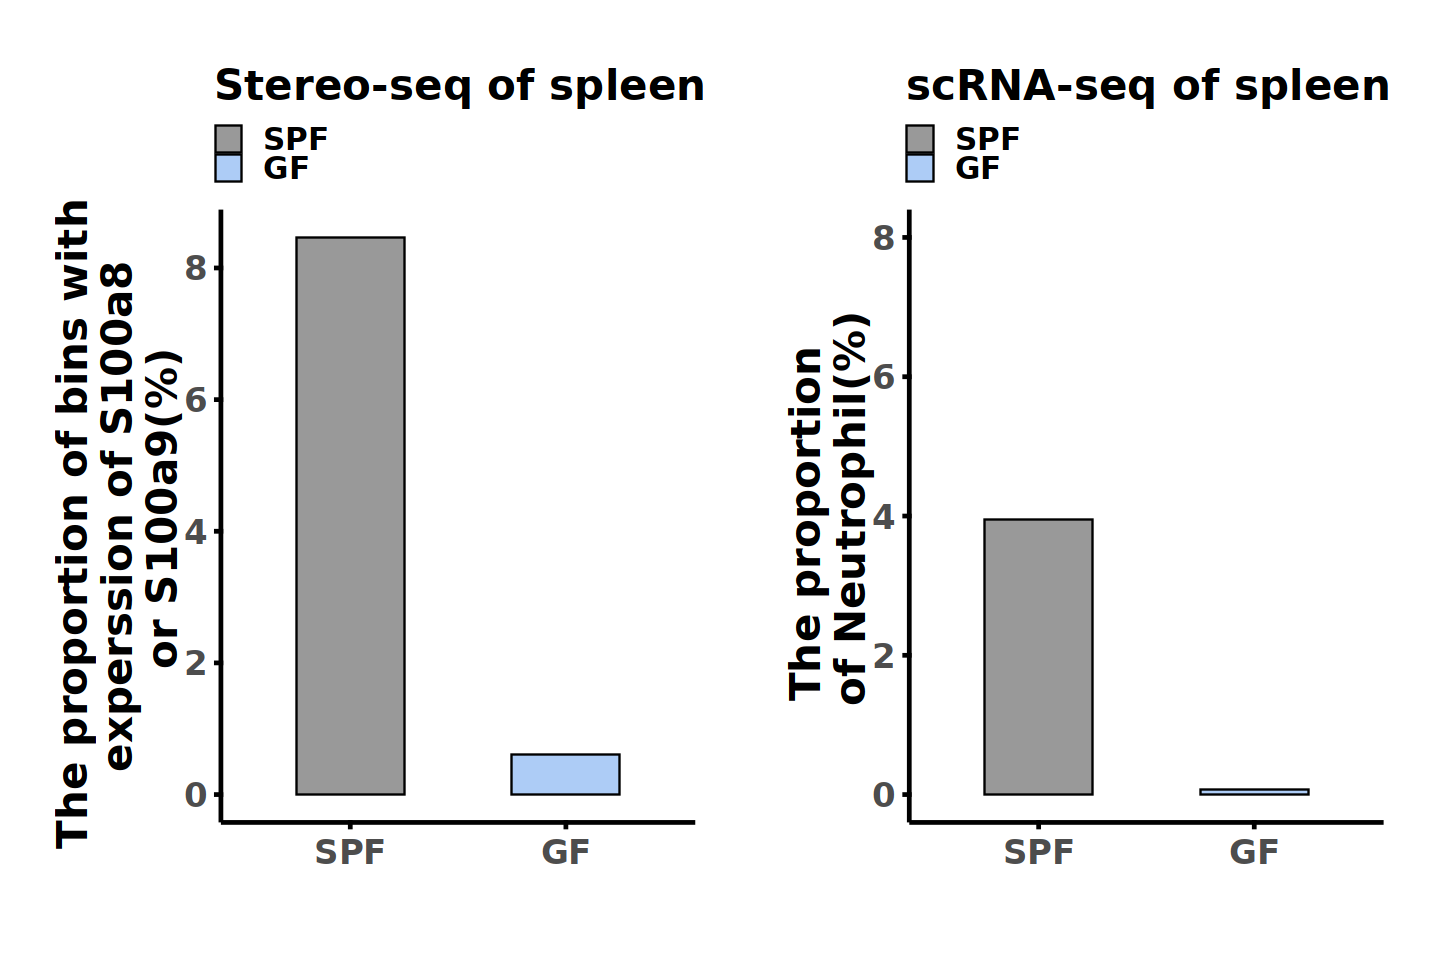

In [63]:
options(repr.plot.width =12,repr.plot.height= 8)
p <- st + sc
p

In [64]:
pdf(file = 'Figure_3E.pdf',w = 12, h = 8)
print(p)
dev.off()

png 
  2

# Figure 3F # python kernel

In [2]:
import datetime
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#import cell2location
# import scvi
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
import warnings
import os
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import pickle
datetime.datetime.now().strftime('%c')

'Tue Jan 14 21:19:52 2025'

In [8]:
def get_rgb_function(cmap, min_value, max_value):
    r"""Generate a function to map continous values to RGB values using colormap between min_value & max_value."""

    if min_value > max_value:
        raise ValueError("Max_value should be greater or than min_value.")

    if min_value == max_value: 
        warnings.warn(
            "Max_color is equal to min_color. It might be because of the data or bad parameter choice. "
            "If you are using plot_contours function try increasing max_color_quantile parameter and"
            "removing cell types with all zero values."
        )

        def func_equal(x):
            factor = 0 if max_value == 0 else 0.5
            return cmap(np.ones_like(x) * factor)

        return func_equal

    def func(x):
        return cmap((np.clip(x, min_value, max_value) - min_value) / (max_value - min_value))

    return func 

def rgb_to_ryb(rgb):
    """
    Converts colours from RGB colorspace to RYB

    Parameters
    ----------

    rgb
        numpy array Nx3

    Returns
    -------
    Numpy array Nx3
    """
    rgb = np.array(rgb)
    if len(rgb.shape) == 1:
        rgb = rgb[np.newaxis, :]

    white = rgb.min(axis=1)
    black = (1 - rgb).min(axis=1)
    rgb = rgb - white[:, np.newaxis]

    yellow = rgb[:, :2].min(axis=1)
    ryb = np.zeros_like(rgb)
    ryb[:, 0] = rgb[:, 0] - yellow
    ryb[:, 1] = (yellow + rgb[:, 1]) / 2
    ryb[:, 2] = (rgb[:, 2] + rgb[:, 1] - yellow) / 2

    mask = ~(ryb == 0).all(axis=1)
    if mask.any():
        norm = ryb[mask].max(axis=1) / rgb[mask].max(axis=1)
        ryb[mask] = ryb[mask] / norm[:, np.newaxis]

    return ryb + black[:, np.newaxis]

def ryb_to_rgb(ryb):
    """
    Converts colours from RYB colorspace to RGB

    Parameters
    ----------

    ryb
        numpy array Nx3

    Returns
    -------
    Numpy array Nx3
    """
    ryb = np.array(ryb)
    if len(ryb.shape) == 1:
        ryb = ryb[np.newaxis, :]

    black = ryb.min(axis=1)
    white = (1 - ryb).min(axis=1)
    ryb = ryb - black[:, np.newaxis]

    green = ryb[:, 1:].min(axis=1)
    rgb = np.zeros_like(ryb)
    rgb[:, 0] = ryb[:, 0] + ryb[:, 1] - green
    rgb[:, 1] = green + ryb[:, 1]
    rgb[:, 2] = (ryb[:, 2] - green) * 2

    mask = ~(ryb == 0).all(axis=1)
    if mask.any():
        norm = rgb[mask].max(axis=1) / ryb[mask].max(axis=1)
        rgb[mask] = rgb[mask] / norm[:, np.newaxis]

    return rgb + white[:, np.newaxis]

# add function of gradient custom # 
def gradient(start_color,end_color,num_steps):
    '''
    Generates a list of gradient colors between two colors
    :parameter 
         start_color : The RGB value of the starting color
         end_color : The RGB value of the ending color
         num_steps : num of gradient colors 
    :return 
        gradient_colors : list of gradient colors
    '''
    r = np.linspace(start_color[0],end_color[0],num_steps)/255
    g = np.linspace(start_color[1],end_color[1],num_steps)/255
    b = np.linspace(start_color[2],end_color[2],num_steps)/255
    # value of RGB to lsit of 
    gradient_colors = np.array([[r[i],g[i],b[i],1]for i in range(num_steps)])
    gradient_colors[:,3] = np.repeat(0.7,num_steps)
    
    return gradient_colors


# plot # 
def plot_spatial_general1(
    value_df,
    coords,
    labels,
    min_intensity = None, # accept number !  
    max_intensity = None,
    text=None,
    circle_diameter=4.0,
    alpha_scaling=1.0,
    max_col=(np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf),
    max_color_quantile=0.98,
    show_img=True,
    img=None,
    img_alpha=1.0,
    adjust_text=False,
    plt_axis="off",
    axis_y_flipped=True,
    x_y_labels=("", ""),
    crop_x=None,
    crop_y=None,
    text_box_alpha=0.9,
    reorder_cmap=range(7),
    style="fast",
    colorbar_position="bottom",
    colorbar_label_kw={},
    colorbar_shape={},
    colorbar_tick_size=12,
    colorbar_grid=None,
    image_cmap="Greys_r",
    white_spacing=20,  
): 
    r"""Plot spatial abundance of cell types (regulatory programmes) with colour gradient and interpolation.

      This method supports only 7 cell types with these colours (in order, which can be changed using reorder_cmap).
      'yellow' 'orange' 'blue' 'green' 'purple' 'grey' 'white'

    :param value_df: pd.DataFrame - with cell abundance or other features (only 7 allowed, columns) across locations (rows)
    :param coords: np.ndarray - x and y coordinates (in columns) to be used for ploting spots
    :param text: pd.DataFrame - with x, y coordinates, text to be printed
    :param circle_diameter: diameter of circles
    :param labels: list of strings, labels of cell types
    :param 
    :param alpha_scaling: adjust color alpha
    :param max_col: crops the colorscale maximum value for each column in value_df.
    :param max_color_quantile: crops the colorscale at x quantile of the data.
    :param show_img: show image?
    :param img: numpy array representing a tissue image.
        If not provided a black background image is used.
    :param img_alpha: transparency of the image
    :param lim: x and y max limits on the plot. Minimum is always set to 0, if `lim` is None maximum
        is set to image height and width. If 'no_limit' then no limit is set.
    :param adjust_text: move text label to prevent overlap
    :param plt_axis: show axes?
    :param axis_y_flipped: flip y axis to match coordinates of the plotted image
    :param reorder_cmap: reorder colors to make sure you get the right color for each category

    :param style: plot style (matplolib.style.context):
        'fast' - white background & dark text;
        'dark_background' - black background & white text;

    :param colorbar_position: 'bottom', 'right' or None
    :param colorbar_label_kw: dict that will be forwarded to ax.set_label()
    :param colorbar_shape: dict {'vertical_gaps': 1.5, 'horizontal_gaps': 1.5,
                                    'width': 0.2, 'height': 0.2}, not obligatory to contain all params
    :param colorbar_tick_size: colorbar ticks label size
    :param colorbar_grid: tuple of colorbar grid (rows, columns)
    :param image_cmap: matplotlib colormap for grayscale image
    :param white_spacing: percent of colorbars to be hidden
    :param color_gradient : TURE of FALSE # lwm add 2024 - 1 - 10
    """
    if value_df.shape[1] > 7: 
        raise ValueError("Maximum of 7 cell types / factors can be plotted at the moment")

    def create_colormap(R, G, B):
        spacing = int(white_spacing * 2.55)

        N = 510 # spleen
        M = 3

        alphas = np.concatenate([[0] * spacing * M, np.linspace(0, 1.0, (N - spacing) * M)])

        vals = np.ones((N * M, 4))
        #         vals[:, 0] = np.linspace(1, R / 255, N * M)
        #         vals[:, 1] = np.linspace(1, G / 255, N * M)
        #         vals[:, 2] = np.linspace(1, B / 255, N * M)
        for i, color in enumerate([R, G, B]):
            vals[:, i] = color / 255
        vals[:, 3] = alphas

        return ListedColormap(vals)

   
    YellowCM = create_colormap(240, 228, 66)  

    RedCM = create_colormap(213, 94, 0)  
    BlueCM = create_colormap(86, 180, 233)  
    GreenCM = create_colormap(0, 158, 115)  
    GreyCM = create_colormap(200, 200, 200)  
    WhiteCM = create_colormap(50, 50, 50)  
    PurpleCM = create_colormap(90, 20, 165)  
    GreenCM2 = create_colormap(139,251,122) 

    cmaps = [YellowCM, RedCM, BlueCM, GreenCM, PurpleCM,GreyCM, WhiteCM, GreenCM2]

    cmaps = [cmaps[i] for i in reorder_cmap]
    
    with mpl.style.context(style):
        fig = plt.figure()

        if colorbar_position == "right":
            if colorbar_grid is None:
                colorbar_grid = (len(labels), 1)

            shape = {"vertical_gaps": 1.5, "horizontal_gaps": 0, "width": 0.15, "height": 0.2}
            shape = {**shape, **colorbar_shape}

            gs = GridSpec(
                nrows=colorbar_grid[0] + 2,
                ncols=colorbar_grid[1] + 1,
                width_ratios=[1, *[shape["width"]] * colorbar_grid[1]],
                height_ratios=[1, *[shape["height"]] * colorbar_grid[0], 1],
                hspace=shape["vertical_gaps"],
                wspace=shape["horizontal_gaps"],
            )
            ax = fig.add_subplot(gs[:, 0], aspect="equal", rasterized=True)

        if colorbar_position == "bottom":
            if colorbar_grid is None:
                if len(labels) <= 3:
                    colorbar_grid = (1, len(labels))
                else:
                    n_rows = round(len(labels) / 3 + 0.5 - 1e-9)
                    colorbar_grid = (n_rows, 3)

            shape = {"vertical_gaps": 0.3, "horizontal_gaps": 0.6, "width": 0.2, "height": 0.035}
            shape = {**shape, **colorbar_shape}

            gs = GridSpec(
                nrows=colorbar_grid[0] + 1,
                ncols=colorbar_grid[1] + 2,
                width_ratios=[0.3, *[shape["width"]] * colorbar_grid[1], 0.3],
                height_ratios=[1, *[shape["height"]] * colorbar_grid[0]],
                hspace=shape["vertical_gaps"],
                wspace=shape["horizontal_gaps"],
            )

            ax = fig.add_subplot(gs[0, :], aspect="equal", rasterized=True)

        if colorbar_position is None:
            ax = fig.add_subplot(aspect="equal", rasterized=True)

        if colorbar_position is not None:
            cbar_axes = []
            for row in range(1, colorbar_grid[0] + 1):
                for column in range(1, colorbar_grid[1] + 1):
                    cbar_axes.append(fig.add_subplot(gs[row, column]))

            n_excess = colorbar_grid[0] * colorbar_grid[1] - len(labels)
            if n_excess > 0:
                for i in range(1, n_excess + 1):
                    cbar_axes[-i].set_visible(False)

        ax.set_xlabel(x_y_labels[0])
        ax.set_ylabel(x_y_labels[1])

        if img is not None and show_img:
            ax.imshow(img, aspect="equal", alpha=img_alpha, origin="lower", cmap=image_cmap)

        # crop images in needed
        if crop_x is not None:
            ax.set_xlim(crop_x[0], crop_x[1])
        if crop_y is not None:
            ax.set_ylim(crop_y[0], crop_y[1])

        if axis_y_flipped:
            ax.invert_yaxis()

        if plt_axis == "off":
            for spine in ax.spines.values():
                spine.set_visible(False)
            ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

        counts = value_df.values.copy() 

        # plot spots as circles
        # print(counts.shape[1])
        c_ord = list(np.arange(0, counts.shape[1]))

        colors = np.zeros((*counts.shape, 4))
        weights = np.zeros(counts.shape)
        
        for c in c_ord:
            print("c: ",c) # lwm
            if isinstance(min_intensity, list):
                min_int = min_intensity[c]
            else :
                min_int = min_intensity
                
            if isinstance(max_intensity, list):
                max_int = max_intensity[c]
            else :
                max_int = max_intensity
            
            if min_int is not None:
                min_color_intensity = min_intensity[c] # 2024 - 2 - 23
            else:
                print(c,"min color intesity is None ! ")
                min_color_intensity = counts[:, c].min()  
            if max_int is not None: 
                max_color_intensity = max_intensity[c] #  2024 - 2 - 23
            else:
                print(c,"max color intensity is None ! ") 
                max_color_intensity = np.min([np.quantile(counts[:, c], max_color_quantile), max_col[c]]) 
            print("min_color_intensity : ",min_color_intensity)
            print("max_color_intensity : ",max_color_intensity)
            
            rgb_function = get_rgb_function(cmap=cmaps[c], min_value=min_color_intensity, max_value=max_color_intensity)
           
            color = rgb_function(counts[:, c])
            color[:, 3] = color[:, 3] * alpha_scaling
            
           
            norm = mpl.colors.Normalize(vmin=min_color_intensity, vmax=max_color_intensity) 
   
                
            if colorbar_position is not None:
                cbar_ticks = [
                    min_color_intensity,
                    np.mean([min_color_intensity, max_color_intensity]),
                    max_color_intensity,
                ]
                cbar_ticks = np.array(cbar_ticks)

                if max_color_intensity > 13:
                    cbar_ticks = cbar_ticks.astype(np.int32)
                else:
                    cbar_ticks = cbar_ticks.round(2)
 
                cbar = fig.colorbar(
                    mpl.cm.ScalarMappable(norm=norm, cmap= cmaps[c]), 
                    cax=cbar_axes[c],
                    orientation="horizontal",
                    extend="both",
                    ticks=cbar_ticks,
                ) 

                cbar.ax.tick_params(labelsize=colorbar_tick_size)
                max_color = rgb_function(max_color_intensity / 1.5)
                cbar.ax.set_title(labels[c], **{**{"size": 20, "color": max_color, "alpha": 1}, **colorbar_label_kw})

            colors[:, c] = color
            weights[:, c] = np.clip(counts[:, c] / (max_color_intensity + 1e-10), 0, 1)
            weights[:, c][counts[:, c] < min_color_intensity] = 0

        colors_ryb = np.zeros((*weights.shape, 3))

        for i in range(colors.shape[0]):
            colors_ryb[i] = rgb_to_ryb(colors[i, :, :3])

        def kernel(w):
            return w**2
        
        # gene expression color spot #
        kernel_weights = kernel(weights[:, :, np.newaxis])
        
        # warning # RuntimeWarning: invalid value encountered in true_divide # 
        weighted_colors_ryb = (colors_ryb * kernel_weights).sum(axis=1) / kernel_weights.sum(axis=1)

        weighted_colors = np.zeros((weights.shape[0], 4))

        weighted_colors[:, :3] = ryb_to_rgb(weighted_colors_ryb)

        weighted_colors[:, 3] = colors[:, :, 3].max(axis=1)
        
        ax.scatter(x=coords[:, 0], y=coords[:, 1], c=weighted_colors, s=circle_diameter**2)
        
        # add text
        if text is not None:
            bbox_props = dict(boxstyle="round", ec="0.5", alpha=text_box_alpha, fc="w")
            texts = []
            for x, y, s in zip(
                np.array(text.iloc[:, 0].values).flatten(),
                np.array(text.iloc[:, 1].values).flatten(),
                text.iloc[:, 2].tolist(),
            ):
                texts.append(ax.text(x, y, s, ha="center", va="bottom", bbox=bbox_props))

            if adjust_text:
                from adjustText import adjust_text

                adjust_text(texts, arrowprops=dict(arrowstyle="->", color="w", lw=0.5))

    return fig,ax
datetime.datetime.now().strftime('%c')

'Tue Jan 14 21:27:13 2025'

In [5]:
def add_ScaleRuler(fig,x,y,length,size,label,lw,local,background):
    r'''
    :para fig: main plot 
    :para x: x axis position of scale ruler
    :para y: y axis position of scale ruler 
    :para length: length of scale ruler
    :para size:  y axis high of scale ruler
    :para label: unit of scale ruler ,Default : "10μm" 
    :para lw: line width,Default : 2
    '''
    if background == "dark_background":
        color = 'white'
    elif background == "fast":
        color = 'black'
    ax = fig.get_axes()
    
    ax[0].hlines(y= y,  xmin = x, xmax = x+length, colors="yellow", ls="-", lw=lw)

    return(fig)

def CreateParaDict(Filelist,Samplelist,Genelist,NoneGenelist,AllGene,
                   Celltypes,SpotSize,Colorlist,Output):
    r'''
    :parameter Filelist : list
    :parameter Samplelist : list
    :parameter NoneGenelist : list
    :parameter Genelist : list 
    :parameter AllGene : list
    :parameter Celltypes : list
    :parameter SpotSize : list
    :parameter Colorlist: list 
    :parameter Output : str
    ...
    '''
    ParaDict = {'filelist' : Filelist,
                'samplelist': Samplelist,
                'NoneGenelist': NoneGenelist,
                'Genelist': Genelist,
                'AllGene': AllGene, 
                'Celltypes': Celltypes,
                'SpotSize': SpotSize,
                'Colorlist': Colorlist,
                'Output': Output}
    return(ParaDict)
datetime.datetime.now().strftime('%c') 

'Tue Jan 14 21:21:09 2025'

In [15]:
def MutilGeneExperssion(ParaDict,min_intensity,max_intensity,Figsize = (8,4),
                        Style = 'dark_background',ColorBarSize = 6,ColorbarTickSize = 6,size=60,
                        ruler_length = 400,label = "200 μm",lw = 4,x_shift = 500,
                        y_local = 600,method = "single"):
    r'''
    :parameter ParaDict : dict
    :parameter min_intensity : 
    :parameter max_intensity : 
    :parameter Figsize : tuple
    :parameter CircleDiameter : number 
    :parameter ColorBarSize : number
    :parameter Style : plot style (matplolib.style.context):
                          'fast' - white background & dark text;
                          'dark_background' - black background & white text;
    :parameter ColorbarTickSize : 
    :parameter size : 
    :parameter ruler.length : 
    :parameter label : 
    :parameter lw : 
    :parameter x.shift :
    :parameter y.local : 
    :parameter method : 
    '''
  
    # parameter #
    filelist = ParaDict['filelist']
    samplelist = ParaDict['samplelist']
    NoneGenelist = ParaDict['NoneGenelist']
    Genelist = ParaDict['Genelist']
    AllGene = ParaDict['AllGene']
    Celltypes = ParaDict['Celltypes']
    Colorlist = ParaDict['Colorlist']
    SpotSize = ParaDict['SpotSize']
    Output = ParaDict['Output']
    
    for i in range(0,len(samplelist)):
        file = filelist[i]
        sample = samplelist[i]
        print("sample: ",sample) # sample
        out = output + "/" + sample
        print(out)
        if(os.path.exists(out)):
            print("Project Exist!")
        else :
            os.mkdir(out) # out project
        
        # input #
        adata = sc.read_h5ad(file)
        sc.pp.normalize_total(adata, target_sum=1e4) # normalize #
        sc.pp.log1p(adata) # log1p #
   
        adata.var.index = adata.var['features']
        GeneExp  = adata.to_df().copy()
        
        # change y axis #
        adata.obs[['y']] = - adata.obs[["y"]] # notice # 
        adata.obsm['spatial'] = adata.obs[["x","y"]].values
        coord = adata.obsm["spatial"]
        
        # Get All Experssion Gene #
        NoneGene = NoneGenelist[i] # NoneGene 
        gene = list(set(AllGene).difference(NoneGene)) # All Experssion Gene 
        gene2 = pd.DataFrame(gene).drop_duplicates()[0].to_list() # duplicate #
        
        # Gene Experssion data.frame #
        GeneExp = GeneExp[gene2]
        
        # celltypes #
        # genelist #
        
        if method == "single": # score or single gene expression   
            print("single")
            for j in range(0,len(Genelist)):
                print(j)
                ct = Celltypes[j] # each celltypes 
                gene3 = Genelist[j]
                genel = list(set(gene3).difference(NoneGene)) # Get each celltypes Experssion Gene 
                CircleDiameter = SpotSize[j]
                color = Colorlist[j]
                if len(genel) > 1 : # cal gene exp score 
                    print("genel: ",genel)
                    score_str = ct + "_score"
                    sc.tl.score_genes(adata,gene_list = genel,
                                    score_name = score_str,use_raw = False) # warnning # 
                    marker = [score_str]
                    GeneExp2 = adata.obs[score_str].to_frame() # only one gene list score
                    
                else :
                    marker = genel
                    GeneExp2 = GeneExp[genel]
               
                print(GeneExp2)
                
                plt.rcParams["figure.figsize"] = Figsize # 
                fig, ax = plot_spatial_general1(value_df=GeneExp2, coords=adata.obsm["spatial"],
                                min_intensity = min_intensity,
                                max_intensity = max_intensity,
                                labels=marker, circle_diameter= CircleDiameter, 
                                style = Style, reorder_cmap = color,
                                colorbar_position="right", 
                                colorbar_tick_size=ColorbarTickSize, 
                                colorbar_label_kw={"size":ColorBarSize}, max_color_quantile=1, img_alpha=1) # 1
                ax.scatter(coord[:,0], coord[:,1], color="#E0E0E0", marker=".", zorder=0, s=0.1)
                fig = add_ScaleRuler(fig = fig,x=adata.obs["x"].max() + x_shift,y=adata.obs["y"].max(),
                                      length = ruler_length,size=size,label=label,lw=lw,background = Style,
                                      local = y_local)
                
        elif method == 'multiple': # multiple Gene Expression # single gene expression  
            print("multiple")
            ct = Celltypes
            CircleDiameter = SpotSize
            color = Colorlist
            genel = list(set(Genelist).difference(NoneGene))
            marker = genel
            GeneExp2 = GeneExp[genel]
            
            print(GeneExp2)

            plt.rcParams["figure.figsize"] = Figsize # 
            
            fig, ax = plot_spatial_general1(value_df=GeneExp2, coords=adata.obsm["spatial"], 
                                min_intensity = min_intensity,
                                max_intensity = max_intensity,
                                labels=marker, circle_diameter= CircleDiameter, 
                                style = Style, reorder_cmap = color,
                                colorbar_position="right", 
                                colorbar_tick_size=ColorbarTickSize,  
                                colorbar_label_kw={"size":ColorBarSize}, max_color_quantile=1, img_alpha=1) 
            ax.scatter(coord[:,0], coord[:,1], color="#E0E0E0", marker=".", zorder=0, s=0.1)

            fig = add_ScaleRuler(fig = fig,x=adata.obs["x"].max() + x_shift ,y=adata.obs["y"].max(),
                                      length = ruler_length,size = size,label=label,background = Style,
                                      lw=lw,local = y_local)
            
            
        else : 
            print("Please check your method!") 
        
        output_fig = out + '/' + sample + "_" + ct + "_gene.pdf"
        print(output_fig)
        fig.savefig(output_fig,dpi = 512)
        print("--- end ----")
        return(fig)
datetime.datetime.now().strftime('%c')  

'Tue Jan 14 21:31:52 2025'

In [22]:
### multiple gene exprssion

genelist = ['S100a9','S100a8'] 
Allgene = ['S100a9','S100a8'] 
Celltypes = 'neutrophil'
Colorlist = [0,1] #  # ['S100a9', 'S100a8']
min_intensity = [0,0]
max_intensity = [4.6,4.6]
# GF  S100a8   max  3.103536609160478
# GF  S100a9   max  3.542611494100682
# SPF S100a8   max  3.4720052111135873  
# SPF S100a9   max  4.566825279680198

In [23]:
filelist  = ['GF_spleen.h5ad']
output = "/data/work/08_plot/Figure3"
samplelist = ["Figure_3F_GF_spleen"]
NoneGenelist =[[]]
SpotSize = 1.5
Dict = CreateParaDict(Filelist = filelist, Samplelist = samplelist,
                      NoneGenelist = NoneGenelist,Genelist = genelist, 
                      AllGene = Allgene,Celltypes = Celltypes,
                      SpotSize = SpotSize,Colorlist = Colorlist,
                      Output=output)

fig1 = MutilGeneExperssion(Dict,min_intensity = min_intensity, max_intensity =  max_intensity,
                    Style = 'dark_background',ColorBarSize = 8,ColorbarTickSize = 10,size = 80,
                    ruler_length = 2000,label = "1000 μm",lw = 2,y_local  = 200,x_shift = 0,
                    method = "multiple")
datetime.datetime.now().strftime('%c')

sample:  Figure_3F_GF_spleen
/data/work/08_plot/Figure3/Figure_3F_GF_spleen
multiple
features        S100a8  S100a9
GF:14550_11350     0.0     0.0
GF:12300_10300     0.0     0.0
GF:10050_11100     0.0     0.0
GF:14150_10950     0.0     0.0
GF:15250_10650     0.0     0.0
...                ...     ...
GF:15900_12350     0.0     0.0
GF:13100_10550     0.0     0.0
GF:9450_9900       0.0     0.0
GF:13500_11200     0.0     0.0
GF:15450_12450     0.0     0.0

[7446 rows x 2 columns]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
2
c:  0
min_color_intensity :  0
max_color_intensity :  4.6
c:  1
min_color_intensity :  0
max_color_intensity :  4.6


/tmp/ipykernel_1406/1845972919.py:349: RuntimeWarning: invalid value encountered in true_divide
  weighted_colors_ryb = (colors_ryb * kernel_weights).sum(axis=1) / kernel_weights.sum(axis=1)


/data/work/08_plot/Figure3/Figure_3F_GF_spleen/Figure_3F_GF_spleen_neutrophil_gene.pdf
--- end ----


'Tue Jan 14 21:44:55 2025'

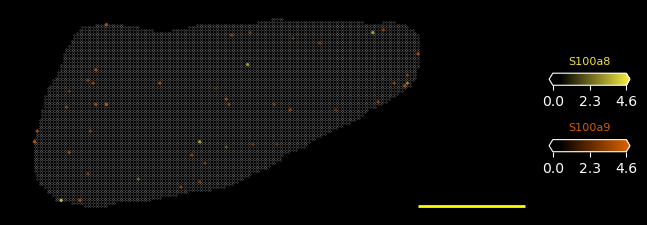

In [24]:
fig1

In [25]:
filelist  = ['SPF_spleen.h5ad']
output = "/data/work/08_plot/Figure3"
samplelist = ["Figure_3F_SPF_spleen"]
NoneGenelist =[[]]

SpotSize = 1.5 

Dict = CreateParaDict(Filelist = filelist, Samplelist = samplelist,
                      NoneGenelist = NoneGenelist,Genelist = genelist, 
                      AllGene = Allgene,Celltypes = Celltypes,
                      SpotSize = SpotSize,Colorlist = Colorlist,
                      Output=output)

fig2 = MutilGeneExperssion(Dict,min_intensity = min_intensity, max_intensity =  max_intensity,
                    Style = 'dark_background',ColorBarSize = 8,ColorbarTickSize = 10,size = 80,
                    ruler_length = 2000,label = "1000 μm",lw = 2,y_local  = 200,x_shift = 0,
                    method = "multiple")
datetime.datetime.now().strftime('%c')

sample:  Figure_3F_SPF_spleen
/data/work/08_plot/Figure3/Figure_3F_SPF_spleen
Project Exist!
multiple
features        S100a8    S100a9
SPF:8700_13550     0.0  0.000000
SPF:7050_14150     0.0  2.067029
SPF:9200_14350     0.0  2.531637
SPF:8650_14000     0.0  0.000000
SPF:11750_9050     0.0  0.000000
...                ...       ...
SPF:6950_12450     0.0  0.000000
SPF:6800_12500     0.0  0.000000
SPF:6950_12550     0.0  0.000000
SPF:7000_12500     0.0  0.000000
SPF:6850_12500     0.0  0.000000

[11957 rows x 2 columns]
[[0.         0.        ]
 [0.         2.06702873]
 [0.         2.53163708]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
2
c:  0
min_color_intensity :  0
max_color_intensity :  4.6
c:  1
min_color_intensity :  0
max_color_intensity :  4.6


/tmp/ipykernel_1406/1845972919.py:349: RuntimeWarning: invalid value encountered in true_divide
  weighted_colors_ryb = (colors_ryb * kernel_weights).sum(axis=1) / kernel_weights.sum(axis=1)


/data/work/08_plot/Figure3/Figure_3F_SPF_spleen/Figure_3F_SPF_spleen_neutrophil_gene.pdf
--- end ----


'Tue Jan 14 21:45:26 2025'

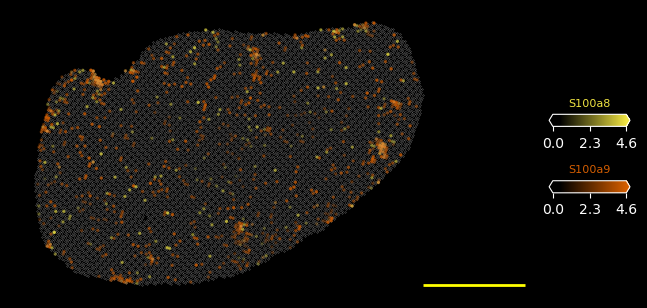

In [26]:
fig2

# Figure 3G

In [6]:
nkt <- readRDS("immune_nkt_final_annotation.rds")

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'CD8αα_1' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'CD8αα_1' in 'mbcsToSbcs': dot substituted for <b1>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'CD8αα_1' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'CD8αα_1' in 'mbcsToSbcs': dot substituted for <b1>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'CD8αα_1' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'CD8αα_1' in 'mbcsToSbcs': dot substituted for <b1>”
Warning message in grid.Call.graph

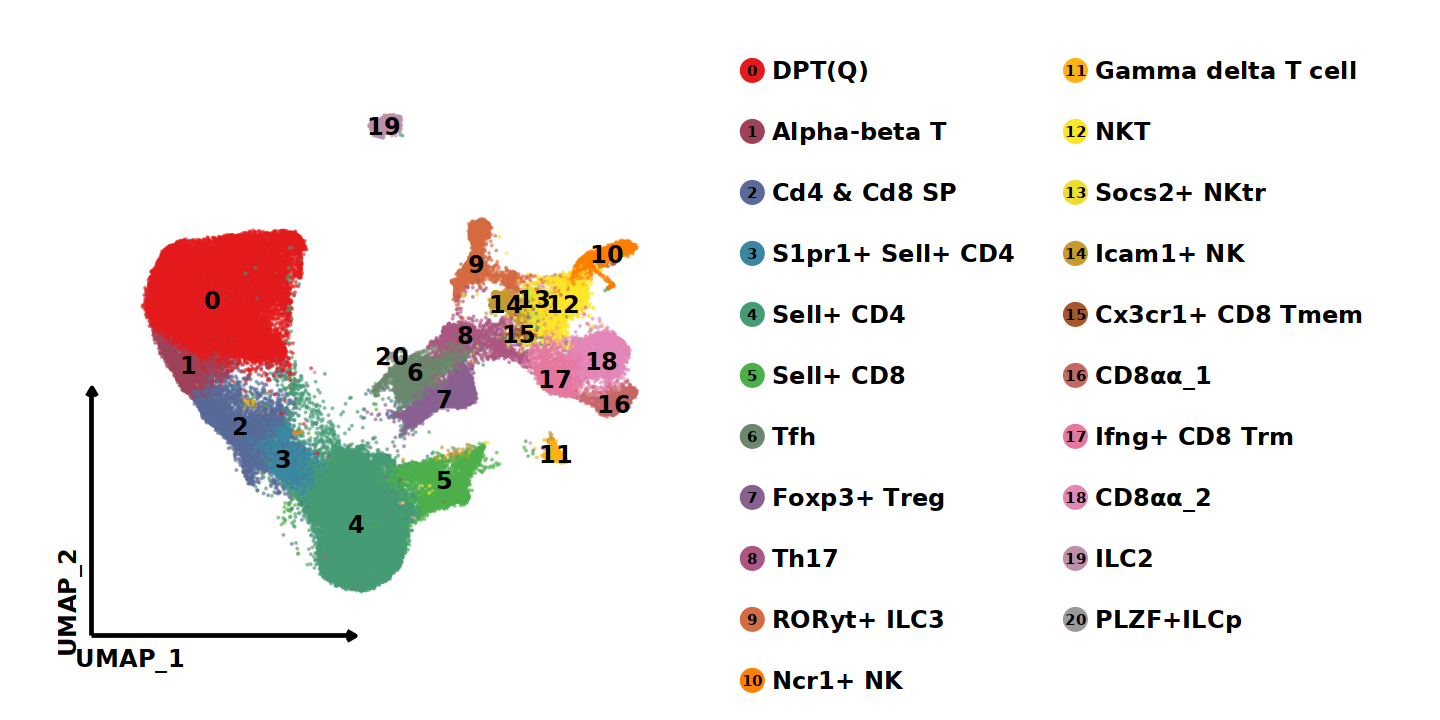

In [164]:
p <- RunUmapPlot(nkt,umapCluster = "Cluster",file_name = "Figure_3G_nkt")
options(repr.plot.width =12,repr.plot.height= 6)
p[["p"]] + p[["lgd"]] 

# Figure 3H

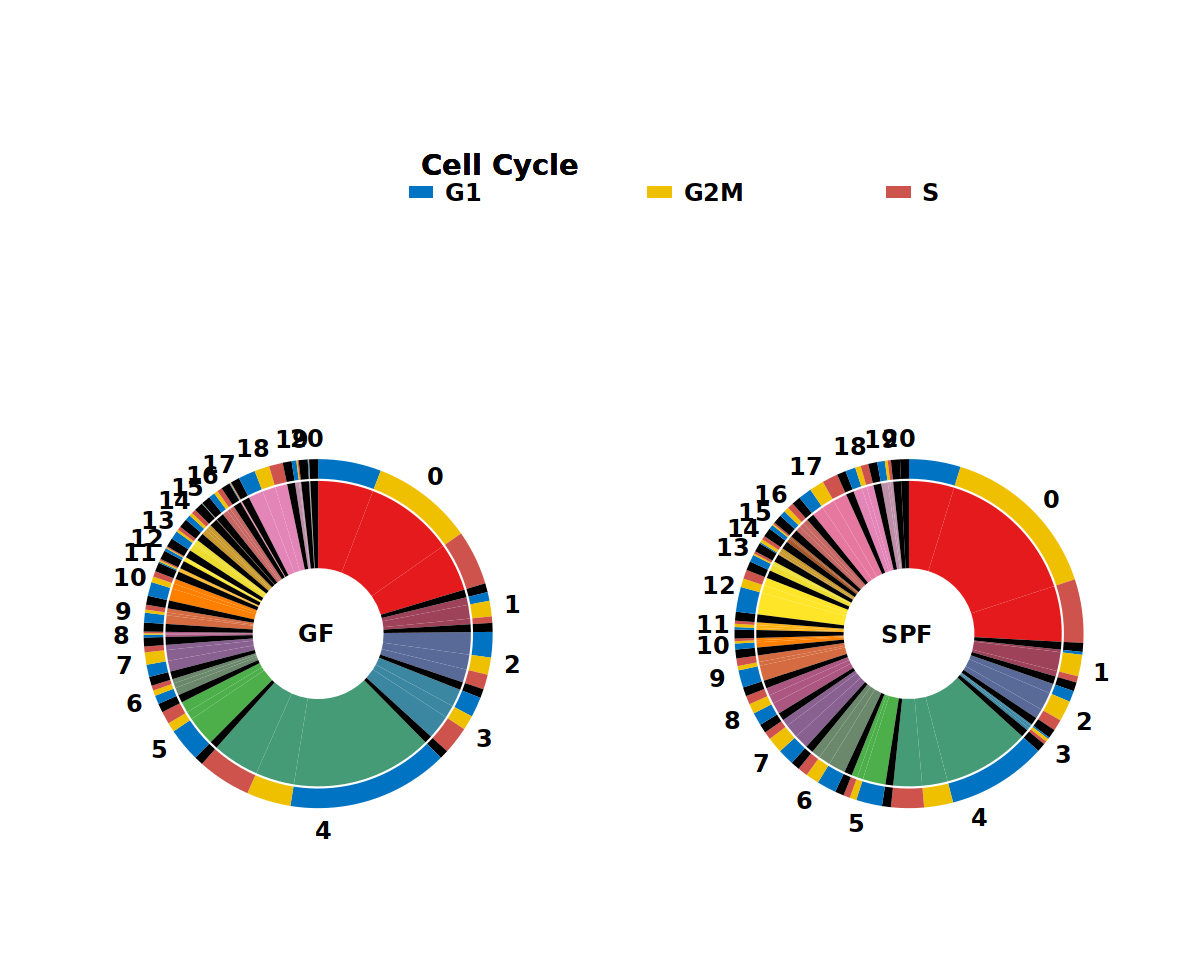

In [165]:
nkt_df <- nkt@meta.data %>% select(mice,Phase,clusters)
write.table(nkt_df,file = "Figure_3H_nkt.xls",sep = "\t",quote = F)
p <- RunCellCyclePlot(data = nkt_df,file_name = "Figure_3H_nkt")
options(repr.plot.width =10,repr.plot.height= 8)
p[["lgd"]] / p[["ccp"]] + plot_layout(heights = c(1,2))

# Figure 3I

In [7]:
nkt_dat <- GetMergeTable(object = nkt, var = "tissue")
rowlist = c(0,1,2,14,3,18,19,9,8,16,17,6,7,4,5,11,13,12,10,15,20)
write.table(nkt_dat,file = "Figure_3I_nkt.xls",sep = '\t',quote = F)

An object of class Seurat 
32862 features across 88680 samples within 2 assays 
Active assay: RNA (30870 features, 0 variable features)
 1 other assay present: integrated
 3 dimensional reductions calculated: pca, umap, tsne
[1] "blood"
[1] "bm"
[1] "liver"
[1] "spleen"
[1] "thymus"
[1] "cecum"
[1] "colon"
[1] "ileum"


 [1]  0  1 10 11 12 13 14 15 16 17 18 19  2 20  3  4  5  6  7  8  9


Warning message:
“Removed 76 rows containing missing values (`geom_point()`).”


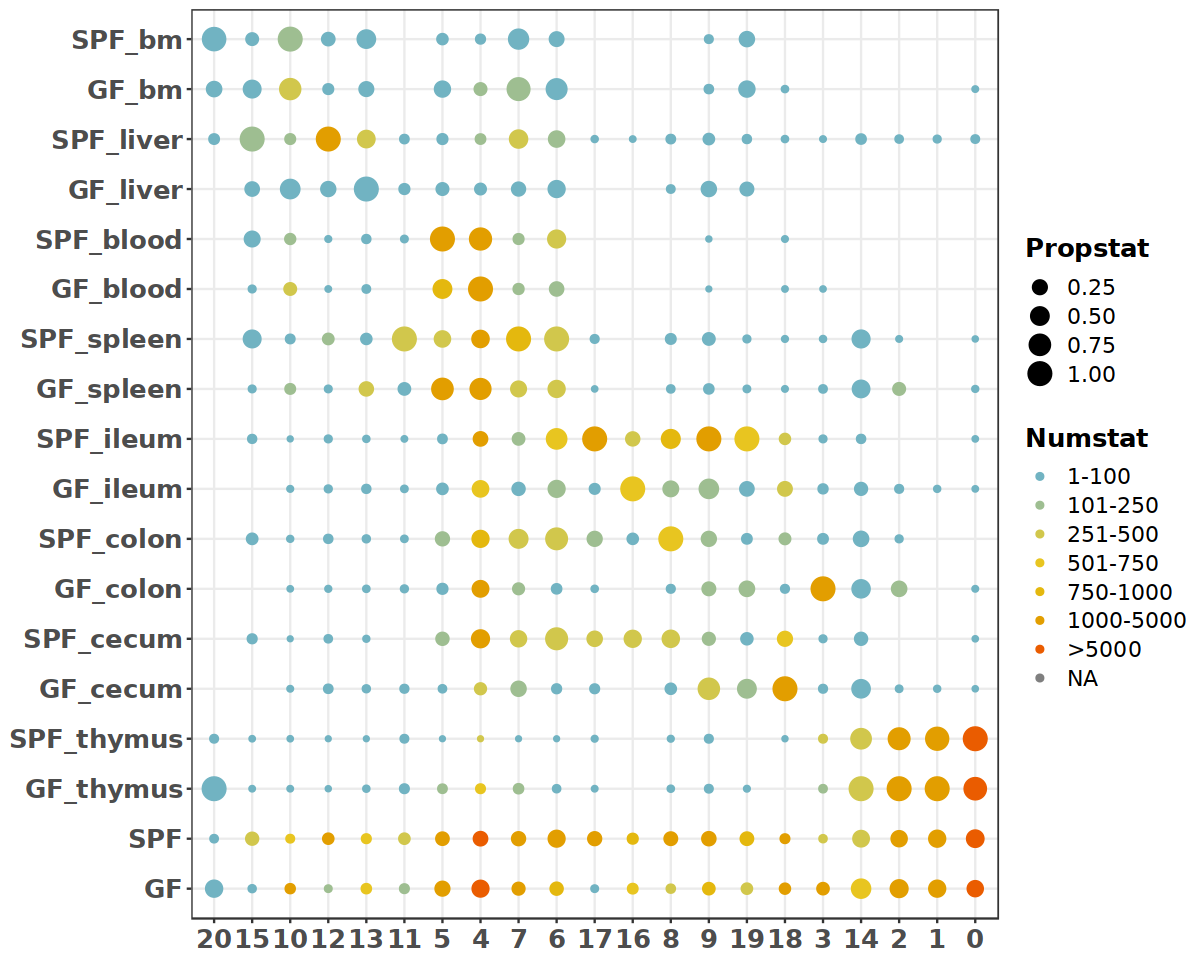

In [9]:
collist <- c("GF","SPF",
             "GF_thymus","SPF_thymus",
             "GF_cecum","SPF_cecum",
             "GF_colon","SPF_colon",  
             "GF_ileum","SPF_ileum",
             "GF_spleen","SPF_spleen",
             "GF_blood","SPF_blood",            
             "GF_liver","SPF_liver",
             "GF_bm","SPF_bm") 
col_names <- c("#3B9AB2","#56A6BA","#71B3C2","#9EBE91","#D1C74C",
               "#E8C520","#E4B80E","#E29E00","#EA5C00","#F21A00")
options(repr.plot.width = 10,repr.plot.height= 8)
p <- dotplot_custom(df_num = nkt_dat, rowlist = rowlist,collist =  collist,col_names = col_names)  
p

In [10]:
pdf(file = 'Figure_3I_nkt_dotplot.pdf',w = 10, h = 8)
print(p)
dev.off()

Warning message:
“Removed 76 rows containing missing values (`geom_point()`).”


png 
  2

# Figure 3J

In [23]:
EechPiePlot <- function(obj,marker){ 
    data <- FetchData(obj,vars = marker)
    data <- data.frame(ExpStat = length(data[data[,marker] != 0,]) ,
                       UnExpStat = length(data[data[,marker] == 0,]),
                       gene = marker)
    data <- reshape2::melt(data,id.vars = "gene")
    print(data)
    data$variable <- factor(data$variable,levels = c("UnExpStat","ExpStat"))
    p <- ggplot(data = data, mapping = aes(x = gene, y = value, fill = variable)) + 
    geom_bar(stat = 'identity',  position = 'stack')+ coord_polar(theta = 'y') +
       scale_fill_manual(values=c("#808080","#bd0000")) + 
       labs(x = '', y = '', title = marker) + theme_void() + theme(
       plot.title = element_text(size = 5,face = "bold",hjust = 0.5),
       legend.position = "none",plot.margin = unit(c(0.1,0.1,0.1,0.1),"cm"))
    return(p)
}

In [24]:
gf_spleen_local <- readRDS("gf_spleen_local.rds")
spf_spleen_local <- readRDS("spf_spleen_local.rds")

In [25]:
Pie1 <- EechPiePlot(obj = gf_spleen_local,marker = "Ctla4")
Pie2 <- EechPiePlot(obj = spf_spleen_local,marker = "Ctla4")

   gene  variable value
1 Ctla4   ExpStat    23
2 Ctla4 UnExpStat  1317
   gene  variable value
1 Ctla4   ExpStat   297
2 Ctla4 UnExpStat  1404


In [ ]:
labels = c("1","2","3","4"), values = c("gray10","gray40","gray70","gray90")

In [49]:
gen_exp_filter=function(rds=spf_local_rds,gene=c("Acta2","Myl9")){
    gen=FetchData(rds,vars=gene)
    nam=rownames(gen)
    gen=apply(gen,1,sum)
   
    x=as.numeric(str_split_fixed(nam, "[:_]", 4)[,2]) #SS200000756BR_E3:13750_6550,格式必须一致
    y=as.numeric(str_split_fixed(nam, "[:_]", 4)[,3]) #SS200000756BR_E3:13750_6550,格式必须一致
    new=data.frame(x,y,gen)
    colnames(new)=c("x","y","hotspot")
    pos=which(new$hotspot==0)
    new=new[-pos,]
    pp=which(new$hotspot>1)
    new$hotspot=0
    new[pp,3]=1
    pp=which(new$hotspot==0)
    new=new[-pp,]
    return(new)
}
plot_region <- function(df, df2, symb="Cr2", point_size,mycolor = c("gray10","gray40","gray70","gray90")) {
  x_med = median(df$x)
  ymin = min(df$y)
  x1 = x_med - 500      # bin50 25um, 200/50 表示4个spot, 4*25=100um,  1000/50 * 25 = 500um
  x2 = x_med + 500
  y1 = ymin - 200
  theme_self <- theme(axis.text = element_blank(), axis.ticks = element_blank(), panel.grid = element_blank(),                                                                                                                                     
          axis.title = element_blank(), axis.line = element_blank(), legend.position = 'right',
          plot.title = element_text(hjust = 0.5,vjust = 0.5,size = 15,face = "bold"))
  R<-ggplot() +  
    geom_contour_filled(df,mapping=aes(x=x, y=y, z=as.numeric(Cell)),breaks=0:5) + theme_void() +                                                                                                                                      
    coord_fixed()  + 
    scale_fill_manual(labels = c("1","2","3","4"), values = mycolor) +
    guides(fill=guide_legend(override.aes = list(size=5), nrow = 4, title = 'Layers'))  + 
    geom_point(df2, mapping=aes(x = x, y = y, color="hotsopt"), shape = 19,
               size = point_size,stroke=NA,col='red') +
    ggtitle(symb)+ 
    guides(colour = guide_legend(override.aes = list(size=3), nrow = 5, title = ''))  + 
    annotate("segment", x = x1, xend = x2, y = y1, yend =y1,size = 1) +
    annotate("text", x = x2 + 500, y = y1, label = "500 μm",color="black",size = 5, fontface="bold" ) + 
    theme_self 
     
  R
}

In [59]:
GF_layer=read.table("GF.bayescluster.cluster_infor.xls",header=T)
df=GF_layer[,c(2,3,6)]
names(df)=c("x","y","Cell")

df_Ctla4_fil=gen_exp_filter(gf_spleen_local,gene="Ctla4")
f1=plot_region(df, df_Ctla4_fil, symb="T cell\n(Ctla4)", point_size=2.5)

In [60]:
SPF_layer=read.table("SPF.bayescluster.cluster_infor.xls",header=T)
df=SPF_layer[,c(2,3,6)]
names(df)=c("x","y","Cell")
rownames(df)=paste("SPF:",df[,1],"_",df[,2],sep="")
 
df_Ctla4_fil=gen_exp_filter(spf_spleen_local,gene="Ctla4")
f2=plot_region(df, df_Ctla4_fil, symb="T cell\n(Ctla4)", point_size=2.5) # 1.8 

In [61]:
layout <- c(area(1,1,4,4),
           area(1,4,1),
           area(5,1,8,4),
           area(5,4,5))

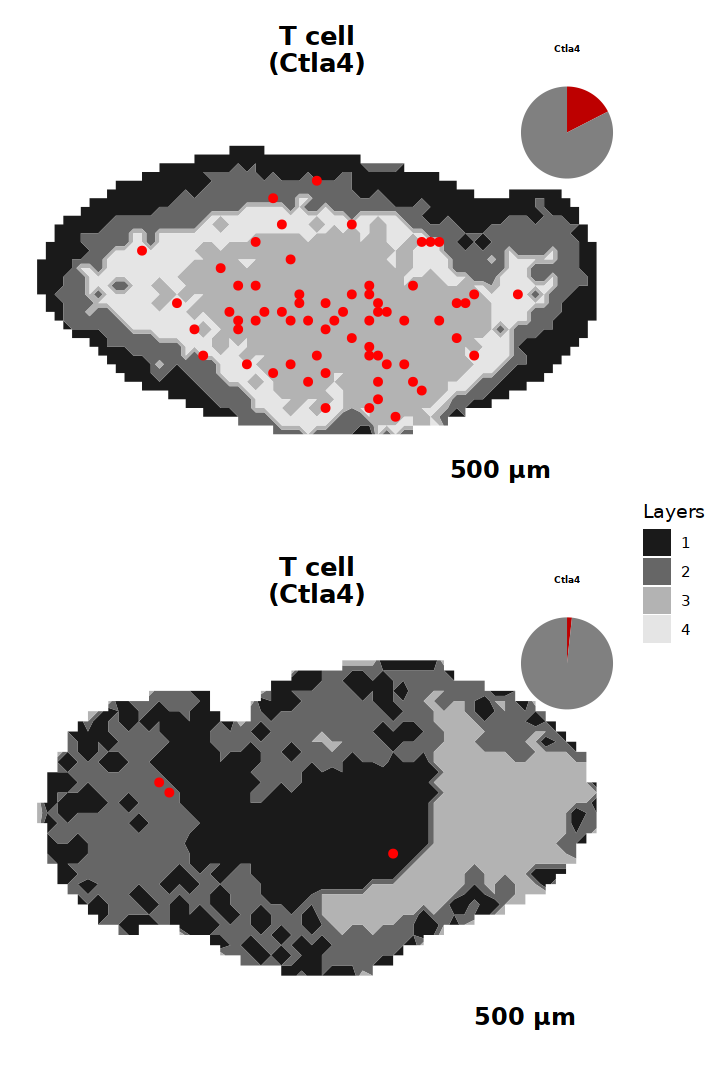

In [63]:
options(repr.plot.width = 6,repr.plot.height = 9)
p <- f2 + Pie2 + f1 + Pie1 +  plot_layout(design = layout,guides='collect')
p

In [64]:
pdf(file = 'Figure_3J.pdf',w = 6, h = 9)
print(p)
dev.off()

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '500 μm' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '500 μm' in 'mbcsToSbcs': dot substituted for <bc>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '500 μm' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '500 μm' in 'mbcsToSbcs': dot substituted for <bc>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '500 μm' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '500 μm' in 'mbcsToSbcs': dot substituted for <bc>”
Warning message in grid.Call.graphics(C_

png 
  2

# Figure 3K

In [65]:
Nd <- read.csv("NKT_all_DEG.xls",sep = "\t") 

In [67]:
CD8aa1 <- Nd %>% filter(celltypes == "CD8αα_1")

In [68]:
library(ggrepel)
DegVolcano <- function(data,title){
  theme_self <- theme(plot.title = element_text(size =25,hjust = 0.5,face = "bold"),
                      axis.text.y = element_text(size = 15,face = "bold",margin = margin(0,5,0,0)),
                      axis.text.x = element_text(size = 15,face = "bold",margin = margin(5,0,0,0)),
                      axis.title.x = element_text(size = 20,face = "bold",margin = margin(10,0,0,0)),
                      axis.title.y = element_text(size = 20,face = "bold",margin = margin(0,10,0,0)))
  p <- ggplot(data,aes(x = avg_log2FC,y = logP,color  = group)) + geom_point(size = 0.2) + 
       geom_vline(xintercept = -0.5,linetype = "longdash",color = "black",size = 0.5) + 
       geom_vline(xintercept = 0.5,linetype = "longdash",color = "black",size = 0.5) + theme_bw() + 
       scale_color_manual(values = c('blue','grey','red')) +
       geom_text_repel(aes(label = Label),size = 5) + labs(x = 'avg_log2FC',y = '-log10(adjPvalue)') + 
      labs(title = paste(title," : CD8αα_1",sep = "")) + theme_self
  return(p)
}

Warning message:
“ggrepel: 38 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


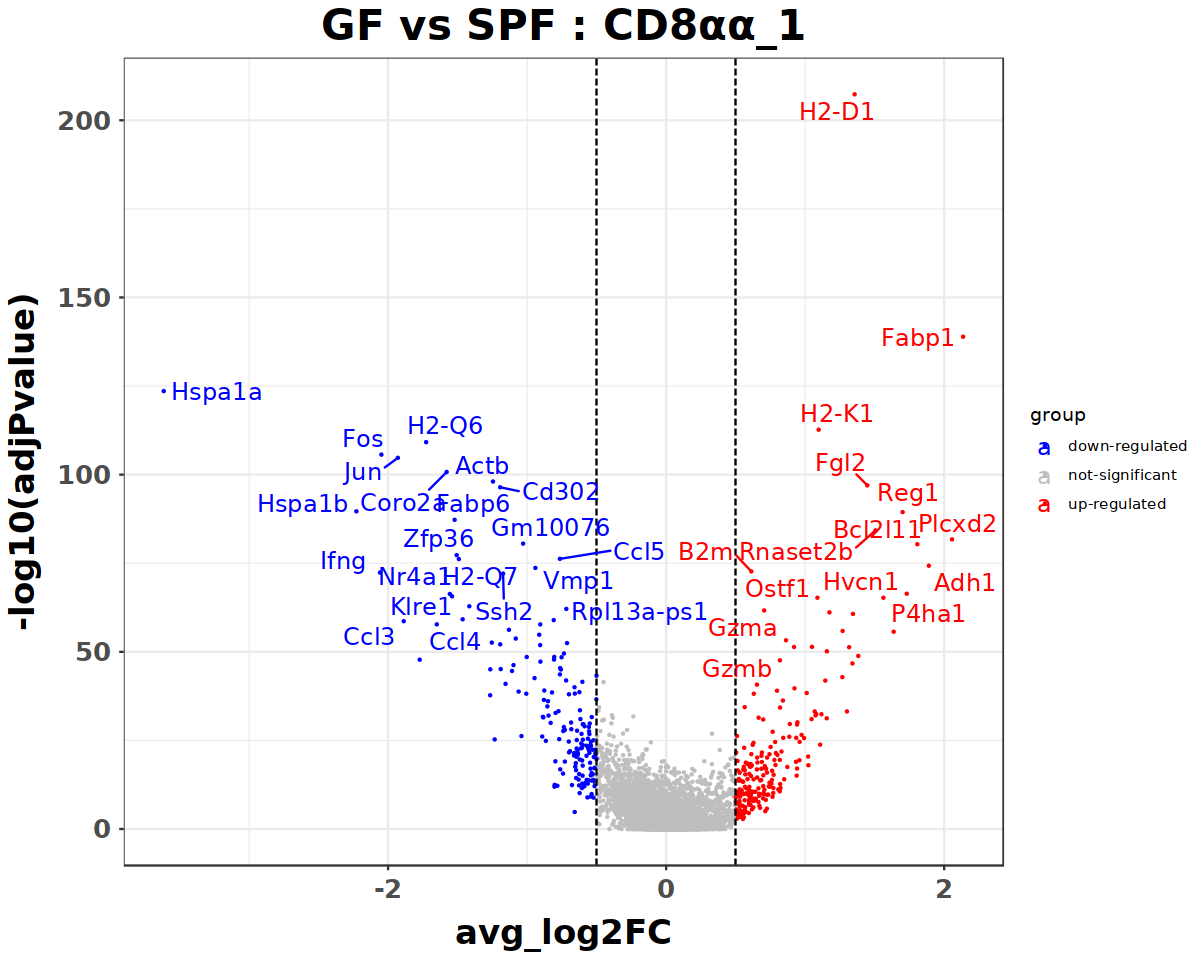

In [69]:
options(repr.plot.width =10,repr.plot.height= 8)
p <- DegVolcano(data = CD8aa1,title = "GF vs SPF") 
p

In [70]:
pdf(file = 'Figure_3K_VolcanoPlot.pdf',w = 6, h = 9)
print(p)
dev.off()

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'GF vs SPF : CD8αα_1' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'GF vs SPF : CD8αα_1' in 'mbcsToSbcs': dot substituted for <b1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'GF vs SPF : CD8αα_1' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'GF vs SPF : CD8αα_1' in 'mbcsToSbcs': dot substituted for <b1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'GF vs SPF : CD8αα_1' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'GF vs SPF : CD8αα_1' in 'mbcsToSbcs': dot su

png 
  2

# Figure 3L

In [72]:
nkt_go <- read.csv("NKT_ALL_GO.xls",sep = "\t")
nkt_cd8aa2 <- nkt_go %>% filter(celltypes == 'CD8αα_1')
date()

[1] "Tue Jan 14 22:28:06 2025"

[1] "GF"  "SPF"


Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


[1] "GF"
[1] "SPF"


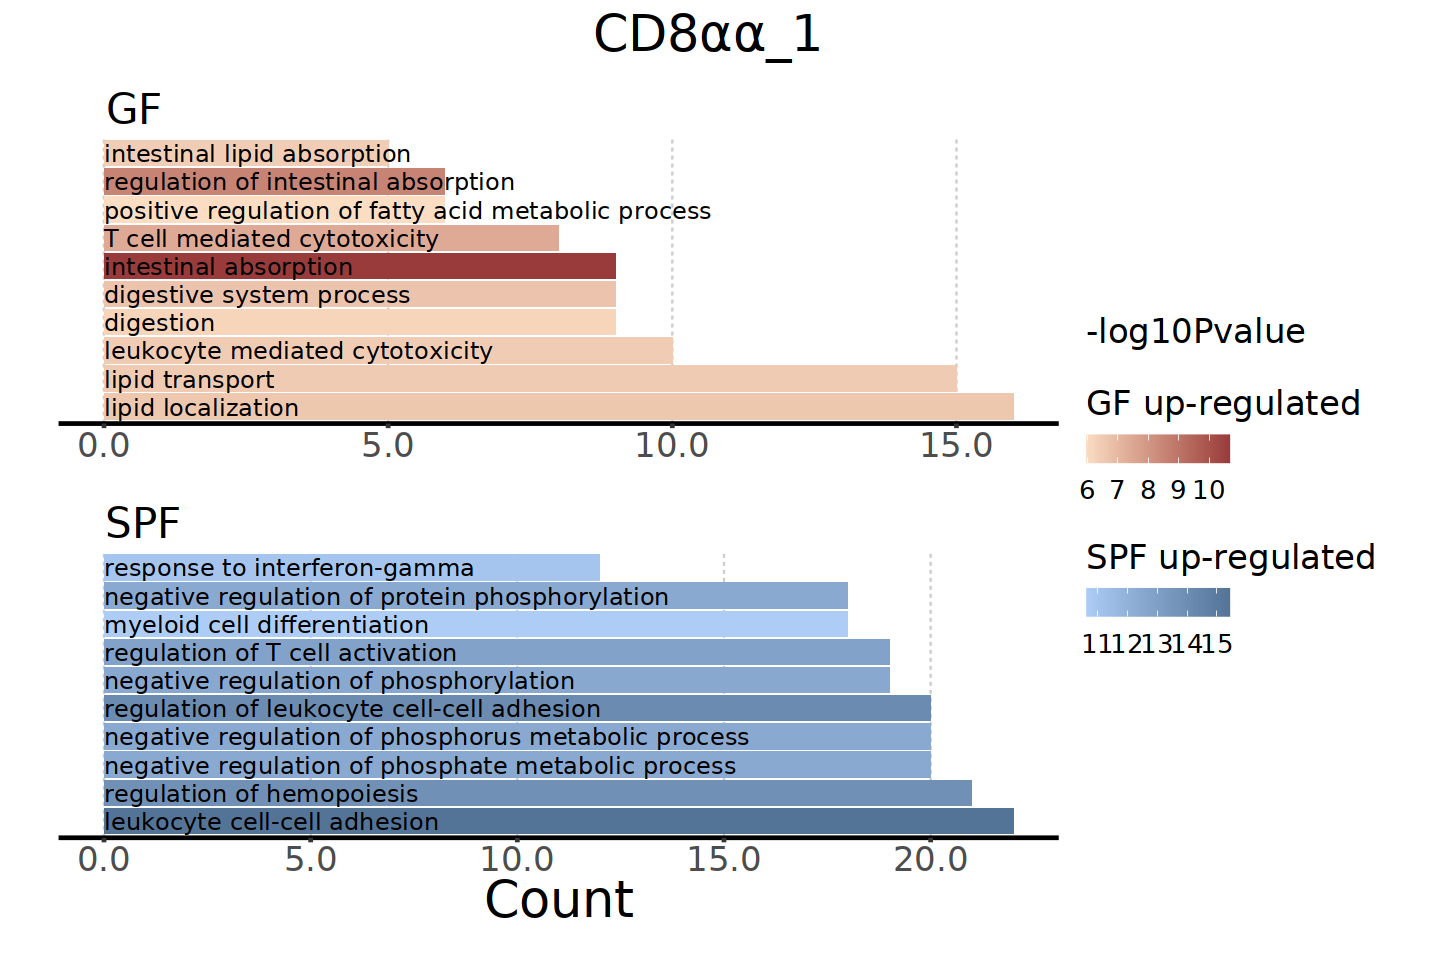

In [73]:
options(repr.plot.width =12,repr.plot.height= 8)
p <- DEGBarplot(dat = nkt_cd8aa2,sample = "CD8αα_1")
p

In [74]:
pdf(file = 'Figure_3L_deg_barplot.pdf',w = 12, h = 8)
print(p)
dev.off()

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'CD8αα_1' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'CD8αα_1' in 'mbcsToSbcs': dot substituted for <b1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'CD8αα_1' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'CD8αα_1' in 'mbcsToSbcs': dot substituted for <b1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'CD8αα_1' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'CD8αα_1' in 'mbcsToSbcs': dot substituted for <b1>”
Warning message in grid.Call(C_textBounds, as.graphi

png 
  2

# Figure 3M

In [75]:
TidyData <- function(deg,features,celltypes = NULL){
    if(!is.null(celltypes)){
        cidx <- deg$celltypes %in% celltypes
        deg <- deg[cidx,]
        cat("After filtering celltypes, DEG size: ",dim(deg),"\n")
    }
    idx <- deg$gene %in% features
    min_fc <- min(deg$avg_log2FC)
    cat("Min avg_log2FC: ",min_fc,"\n")
    max_fc <- max(deg$avg_log2FC)
    cat("Max avg_log2FC: ",max_fc,"\n")
    dat <- spread(deg[idx,c("avg_log2FC","celltypes","gene")],gene,avg_log2FC)
    rownames(dat) <- dat$celltypes
    dat <- dat[,-1]
    return(dat)
}

In [80]:
# input # 
Md <- read.csv("Myeloid_all_DEG.txt",sep = "\t")
Nd <- read.csv("NKT_all_DEG.xls",sep = "\t")

# merge # 
me <- rbind(Md,Nd)

# get heatmap plot data # 
ct <- c('Macrophage(Acp5 high)','Macrophage(Gpnmb high)','Macrophage(Retnla high)','Monoctye',
        'Foxp3+ Treg','Ifng+ CD8 Trm','RORyt+ ILC3','Th17')
cidx <- me$celltypes %in% ct
mef <- me[cidx,]
features <- c('Il17a','Il22','Rorc','Ifng','Il1b','Tnf')
data <- TidyData(deg = mef,features = features)

# arrange x and y axis 
data <- data[ct,] 
data <- data[,features]
write.table(data,file = "Figure_3M_immune_deg_stat.xls",quote = F,sep = "\t")

Min avg_log2FC:  -4.370788 
Max avg_log2FC:  3.977331 


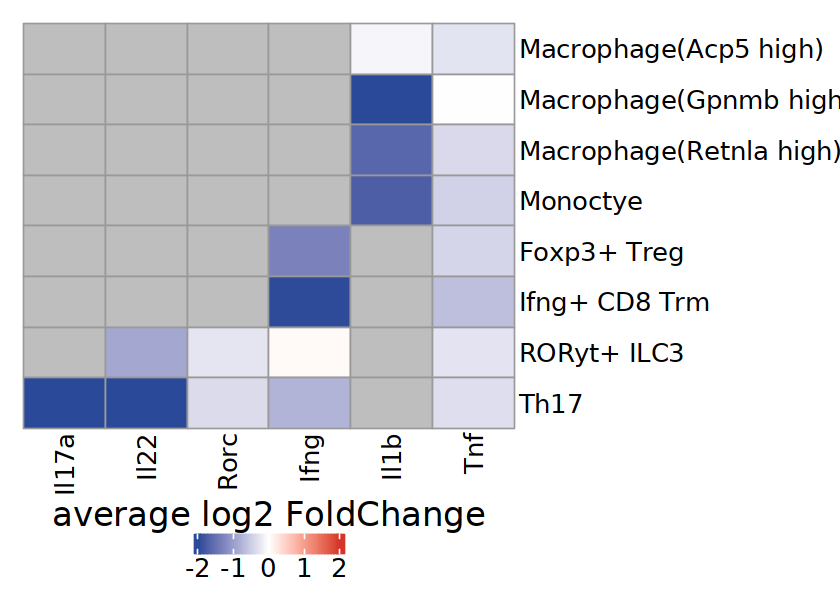

In [81]:
cols = colorRamp2(c(-2, 0, 2), c("#2A4999", "white", "#d43429"))
p <- ComplexHeatmap::pheatmap(as.matrix(data), name = "DEG",col = cols,
             cluster_rows = FALSE, 
             cluster_cols = FALSE,fontsize = 15,
             heatmap_legend_param = list(
                 title = "average log2 FoldChange",
                 legend_direction = "horizontal",
                 legend_height = unit(4, "cm"),
                 side = "bottom",
                 title_gp = gpar(col = "black", fontsize = 20),
                  labels_gp = gpar(col = "black", fontsize = 15),
                 title_position = "topcenter"
))
options(repr.plot.width = 7,repr.plot.height= 5)
p2 <- draw(p, heatmap_legend_side="bottom", annotation_legend_side="right",
     legend_grouping = "original",padding = unit(c(5, 5, 5, 7), "mm"))

In [82]:
pdf(file = 'Figure_3M_immnue_deg_heatmap.pdf',w = 7, h = 5)
print(p)
dev.off()

png 
  2